# N.B.

After this notebook, we will switch back to Julia language.
The reasons are threefold:

* Julia provides a decent performance boost for free;
* Julia is the main language at LakeTide, technical support has neither distance nor latency;
* Julia has better support for OpenStreetMap, which is needed for future traffic simulation.

Switching from Julia to Python was not a bad idea per se;
Python plus Networkx worked quite well in the last two weeks as
the tool set to conduct the proof of concepts; currently, new
needs demand new set of tools.

# Heads-Up

In this notebook, we scale up the graph to 1000 nodes;
this makes the size of samples around one billion, which
makes it impossible to be generated and further augmented.

The way to cope with that is to randomly sample pairs of nodes
and generate training data from them. Idealy, the training size
before augmentation is around one millon.

The meaning of this stocastic manner is twofold.
* it reduced the complexity of training set generation massively
* this is a decent test to see if the model is truly able to generalize

# Problems

The algorithm does not seem to work well with a graph
of 1000 nodes, which is somehow disappointing.

Possible reasons are the following:

* The model is not powerful enough to learn the graph;
* The stochastic sampling of training data does not show the model the big picture, i.e.,
the model gets confused by the edges it has never seen before;

* The training sample should allow the model the take steps back, i.e., for each sample
path, the parent nodes should be included;

However, after deeper analysis, we tend to believe that it is certain properties of 
the graph that make the current model much harder to be trained and to infer. ("./Mar_19/")

# Make it "smarter" TODO

* Detect dead loop;
* <del>Include the parent nodes for training</del> (**tests show that this makes the model harder to be trained and less "intelligent"**)
* Randomize the input vectors during inference
* Add a new heuristic, i.e., for each first order edge, 
look ahead a certain number of steps and use a greedy
strategy to always go with the edge with the largest centrality;
(adding the last node might help, geo-location, cos-distance, Euclidean-distance etc.)

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g

In [2]:
NUM_NODE = 100
WEIGHT_MIN = .5
WEIGHT_MAX = 1.

In [3]:
def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(num_nodes=100,\
                          min_out_degree=2,\
                          max_out_degree=4,\
                          weight_min=WEIGHT_MIN,\
                          weight_max=WEIGHT_MAX,\
                          grid_size=20000):
    
    G = nx.Graph()
    
    euclidean_coords = np.linspace(0.0, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            geo_dist = calc_euclidean_dist(G, tmp_node[0], node)
            
            G.add_edge(node, tmp_node[0], weight=weight * geo_dist)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
        
    return G

4
2
100
170


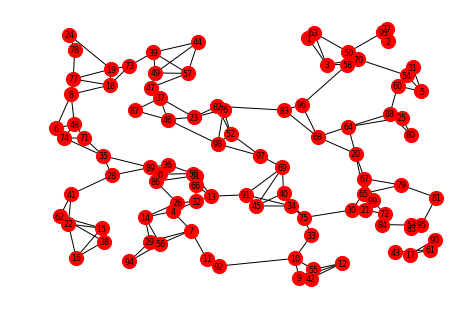

In [5]:
# G = nx.read_gpickle("./Mar_19/graph.pickle")

G = generate_low_degree_g()
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())

plot_g(G, with_labels=True, node_size=200, font_size=8)

In [220]:
from networkx import NetworkXNoPath

def calc_cosine_dist(p1, p2):
    return np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

def find_central_edge_greedy(G, start, depth=3):
    
    cur_node = start
    path = [cur_node]
    
    centrality_sum = 0.0
    
    for d in range(depth + 1):
        
        edge_tuples = map(lambda e:(e[0], e[1], G.get_edge_data(e[0], e[1])['centrality']),\
                  G.edges(cur_node))
        
#         print(cur_node)
#         print(edge_tuples)
#         print('')
        chosen_edge = max(edge_tuples, key=lambda t:t[2])
        
        assert cur_node == chosen_edge[0]
        cur_node = chosen_edge[1]
        
        # No point of getting trapped
        # in a dead loop;
        # just break out
        if cur_node in path:
            break
        
        centrality_sum += chosen_edge[2]
        path.append(cur_node)
    
    return centrality_sum

def encode_edges(G, parent, node, src, dst):
    
    ret = np.zeros((max_degree, 7))
    ret[:, -1] = -1
    
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    x_src = G.nodes[src]['x']
    y_src = G.nodes[src]['y']
    
    for idx, edge in enumerate(G.edges(node)):
        u = edge[0]
        v = edge[1]
        
        # Only look forward
        # allow look backwards(shouldn't be included)
        if v == parent:
            continue
        
        ret[idx][0] = G.get_edge_data(u, v)['centrality']
        ret[idx][1] = G.get_edge_data(u, v)['weight']
        
        x_u = G.nodes[u]['x']
        y_u = G.nodes[u]['y']
        x_v = G.nodes[v]['x']
        y_v = G.nodes[v]['y']

        ret[idx][2] = calc_cosine_dist((x_v-x_u, y_v-y_u), (x_dst-x_u, y_dst-y_u))
        ret[idx][3] = calc_euclidean_dist(G, v, dst)
        ret[idx][4] = x_v
        ret[idx][5] = y_v
        ret[idx][-1] = v
        
    return (ret, x_src, y_src, x_dst, y_dst)

def generate_stochastic_dataset(G, num_train_node_pairs=400,\
                                    num_test_node_pairs=100, verbose_frequence=100):
    
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []
    
    pair_path_dict = dict()
    
    train_selected_pairs = []
    test_selected_pairs = []
    num_of_nodes = G.number_of_nodes()
    
    train_mode = True
    
    while True:
        src = np.random.randint(0, num_of_nodes)
        dst = np.random.randint(0, num_of_nodes)
        
        if src == dst:
            continue
        
        if (src, dst) in pair_path_dict:
            continue
        
        try:
            shortest_path = nx.dijkstra_path(G, src, dst)
                
        except NetworkXNoPath:
#                 print("No path between %d and %d" % (src, dst))
            continue
    
        for path in [shortest_path, shortest_path[::-1]]:
            
            src = path[0]
            dst = path[-1]
            
            pair_path_dict[(src, dst)] = path
            
            if train_mode and len(train_selected_pairs) < num_train_node_pairs:
                train_selected_pairs.append((src, dst))
            else:
                train_mode = False
                if len(test_selected_pairs) < num_test_node_pairs:
                    test_selected_pairs.append((src, dst))
                    
            parent_node = -1
            cur_node = src
            for mid_node in path[1:]:

#                 print('parent:(%d), X:(%d, %d), y:(%d)' % (parent_node, cur_node, dst, mid_node))
                if train_mode:
                    train_features.append(encode_edges(G, parent_node, cur_node, src, dst))
                    train_labels.append(mid_node)
                else:
                    test_features.append(encode_edges(G, parent_node, cur_node, src, dst))
                    test_labels.append(mid_node)
                
                parent_node = cur_node
                cur_node = mid_node
                
#                 sample_cnt += 1
                
#                 if sample_cnt % frequent == 0:
#                     print("Collected %d samples." % (sample_cnt))
        
#         print('len of train_selected_pairs: %d' % len(train_selected_pairs))
#         print('len of test_selected_pairs: %d' % len(test_selected_pairs))
        if len(train_selected_pairs) >= num_train_node_pairs \
            and len(test_selected_pairs) >= num_test_node_pairs:
            break
        
    return train_features, train_labels, test_features, test_labels, train_selected_pairs, test_selected_pairs, pair_path_dict

In [46]:
def find_label_idx(feature, label):
    
    for idx, row in enumerate(feature):
        if label == row[-1]:
            break
    
    return idx

def augment_dataset(X, y, augmentation=False, augmentation_index=20, print_freq=300000):
    
    sample_size = len(y)
    augmented_sample_size = augmentation_index * sample_size
    feature_size = 28
    
    X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)
    indices = np.arange(max_degree)
    
    cnt = 0
    for feature, label in zip(X, y):
        for _ in range(augmentation_index):
            
            if augmentation:
                np.random.shuffle(indices)
            
            feature_tmp = feature[0][indices]
            label_tmp = find_label_idx(feature_tmp, label)
            
            X_aug[cnt] = np.append(feature_tmp[:, :-1].reshape(-1), [feature[1], feature[2], feature[3], feature[4]])
            y_aug[cnt] = label_tmp
            
            cnt += 1
            
#             if cnt % print_freq == 0:
#                 print("Processed %d samples" % (cnt))
            
    return X_aug, y_aug

In [138]:
def generate_samples_from_graph(num_node_pairs, graph_size=100, augmentation=False, augmentation_index=1, label='Train'):
    
    G = generate_low_degree_g(num_nodes=graph_size)
    
#     plot_g(G, with_labels=True, node_size=200, font_size=8)
    
    features, labels, _, _, selected_pairs, _, pair_path_dict =\
            generate_stochastic_dataset(G, num_train_node_pairs=num_node_pairs, num_test_node_pairs=0)
        
    X, y = augment_dataset(features, labels,\
                           augmentation=augmentation,
                           augmentation_index=augmentation_index, \
                           print_freq=600)
    
    assert len(features) == len(labels)
#     assert len(y) == len(labels)
    assert len(X) == len(y)
    
#     print(label)
#     print("%d pairs are selected for training" % (len(selected_pairs)))
#     print("len of pair_path_dict: %d" % (len(pair_path_dict)))
#     print("Num of training sample: %d" % len(y))
#     print(label)
#     print('\n')
    
    return X, y, G, pair_path_dict

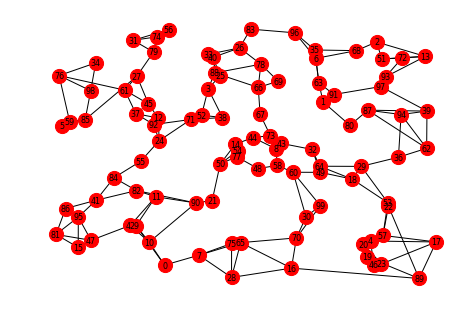

Train
2000 pairs are selected for training
len of pair_path_dict: 2000
Num of training sample: 184760
Train




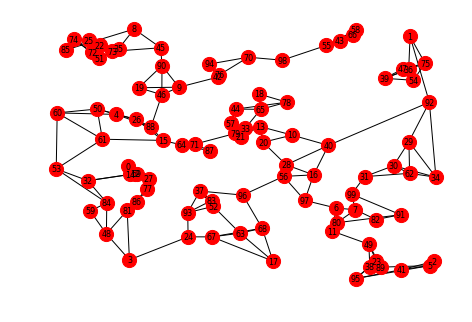

Validation
200 pairs are selected for training
len of pair_path_dict: 200
Num of training sample: 1890
Validation




In [52]:
X_train, y_train, G_train = generate_samples_from_graph(num_node_pairs=2000, augmentation=True, augmentation_index=10, label='Train')
X_val, y_val, G_val = generate_samples_from_graph(num_node_pairs=200, augmentation=False, label='Validation')

In [53]:
batch_size = 128

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_val, y_val, batch_size=batch_size)

In [63]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc1  = mx.sym.FullyConnected(data=data, num_hidden=2048)
    fc1 = mx.sym.Activation(data=fc1, act_type="relu")
    fc1 = mx.sym.Dropout(data=fc1)
    
    fc2  = mx.sym.FullyConnected(data=fc1, num_hidden=1024)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    fc2 = mx.sym.Dropout(data=fc2)
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [118]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [119]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 200),
#               epoch_end_callback = mx.callback.do_checkpoint("mymodel", 1),
              num_epoch=50) 

INFO:root:Epoch[0] Batch [200]	Speed: 28061.84 samples/sec	accuracy=0.812034
INFO:root:Epoch[0] Batch [400]	Speed: 33426.78 samples/sec	accuracy=0.852305
INFO:root:Epoch[0] Batch [600]	Speed: 35958.48 samples/sec	accuracy=0.849375
INFO:root:Epoch[0] Batch [800]	Speed: 36586.12 samples/sec	accuracy=0.855820
INFO:root:Epoch[0] Batch [1000]	Speed: 35066.38 samples/sec	accuracy=0.853398
INFO:root:Epoch[0] Train-accuracy=0.858273
INFO:root:Epoch[0] Time cost=4.424
INFO:root:Epoch[0] Validation-accuracy=0.858333
INFO:root:Epoch[1] Batch [200]	Speed: 34214.82 samples/sec	accuracy=0.861085
INFO:root:Epoch[1] Batch [400]	Speed: 29341.65 samples/sec	accuracy=0.866445
INFO:root:Epoch[1] Batch [600]	Speed: 23510.83 samples/sec	accuracy=0.869766
INFO:root:Epoch[1] Batch [800]	Speed: 34736.08 samples/sec	accuracy=0.867109
INFO:root:Epoch[1] Batch [1000]	Speed: 35018.89 samples/sec	accuracy=0.865820
INFO:root:Epoch[1] Batch [1200]	Speed: 34126.78 samples/sec	accuracy=0.867227
INFO:root:Epoch[1] Batch

INFO:root:Epoch[12] Batch [1000]	Speed: 27407.11 samples/sec	accuracy=0.883828
INFO:root:Epoch[12] Batch [1200]	Speed: 34291.76 samples/sec	accuracy=0.888359
INFO:root:Epoch[12] Batch [1400]	Speed: 35134.67 samples/sec	accuracy=0.887031
INFO:root:Epoch[12] Train-accuracy=0.880814
INFO:root:Epoch[12] Time cost=5.652
INFO:root:Epoch[12] Validation-accuracy=0.907292
INFO:root:Epoch[13] Batch [200]	Speed: 35704.18 samples/sec	accuracy=0.889809
INFO:root:Epoch[13] Batch [400]	Speed: 35999.70 samples/sec	accuracy=0.892734
INFO:root:Epoch[13] Batch [600]	Speed: 35958.49 samples/sec	accuracy=0.892344
INFO:root:Epoch[13] Batch [800]	Speed: 33820.64 samples/sec	accuracy=0.890195
INFO:root:Epoch[13] Batch [1000]	Speed: 35992.16 samples/sec	accuracy=0.887852
INFO:root:Epoch[13] Batch [1200]	Speed: 31365.32 samples/sec	accuracy=0.890508
INFO:root:Epoch[13] Batch [1400]	Speed: 27510.02 samples/sec	accuracy=0.890391
INFO:root:Epoch[13] Train-accuracy=0.886810
INFO:root:Epoch[13] Time cost=5.559
INFO:

INFO:root:Epoch[24] Batch [1200]	Speed: 34563.81 samples/sec	accuracy=0.889922
INFO:root:Epoch[24] Batch [1400]	Speed: 36091.41 samples/sec	accuracy=0.893203
INFO:root:Epoch[24] Train-accuracy=0.887718
INFO:root:Epoch[24] Time cost=5.550
INFO:root:Epoch[24] Validation-accuracy=0.908333
INFO:root:Epoch[25] Batch [200]	Speed: 34947.43 samples/sec	accuracy=0.896727
INFO:root:Epoch[25] Batch [400]	Speed: 32977.88 samples/sec	accuracy=0.896563
INFO:root:Epoch[25] Batch [600]	Speed: 28001.70 samples/sec	accuracy=0.898164
INFO:root:Epoch[25] Batch [800]	Speed: 29892.44 samples/sec	accuracy=0.896016
INFO:root:Epoch[25] Batch [1000]	Speed: 33742.73 samples/sec	accuracy=0.890742
INFO:root:Epoch[25] Batch [1200]	Speed: 34165.26 samples/sec	accuracy=0.893203
INFO:root:Epoch[25] Batch [1400]	Speed: 35408.76 samples/sec	accuracy=0.895391
INFO:root:Epoch[25] Train-accuracy=0.892442
INFO:root:Epoch[25] Time cost=5.703
INFO:root:Epoch[25] Validation-accuracy=0.909896
INFO:root:Epoch[26] Batch [200]	Spe

INFO:root:Epoch[36] Batch [1400]	Speed: 32141.59 samples/sec	accuracy=0.891992
INFO:root:Epoch[36] Train-accuracy=0.888990
INFO:root:Epoch[36] Time cost=5.796
INFO:root:Epoch[36] Validation-accuracy=0.909375
INFO:root:Epoch[37] Batch [200]	Speed: 34107.14 samples/sec	accuracy=0.895173
INFO:root:Epoch[37] Batch [400]	Speed: 35714.49 samples/sec	accuracy=0.891563
INFO:root:Epoch[37] Batch [600]	Speed: 35503.39 samples/sec	accuracy=0.896602
INFO:root:Epoch[37] Batch [800]	Speed: 35802.19 samples/sec	accuracy=0.895508
INFO:root:Epoch[37] Batch [1000]	Speed: 33866.65 samples/sec	accuracy=0.891836
INFO:root:Epoch[37] Batch [1200]	Speed: 36081.09 samples/sec	accuracy=0.890430
INFO:root:Epoch[37] Batch [1400]	Speed: 31692.39 samples/sec	accuracy=0.892461
INFO:root:Epoch[37] Train-accuracy=0.887355
INFO:root:Epoch[37] Time cost=5.372
INFO:root:Epoch[37] Validation-accuracy=0.906771
INFO:root:Epoch[38] Batch [200]	Speed: 28411.20 samples/sec	accuracy=0.893657
INFO:root:Epoch[38] Batch [400]	Spee

INFO:root:Epoch[48] Train-accuracy=0.893532
INFO:root:Epoch[48] Time cost=5.673
INFO:root:Epoch[48] Validation-accuracy=0.895833
INFO:root:Epoch[49] Batch [200]	Speed: 36264.54 samples/sec	accuracy=0.897310
INFO:root:Epoch[49] Batch [400]	Speed: 34197.95 samples/sec	accuracy=0.894375
INFO:root:Epoch[49] Batch [600]	Speed: 27417.24 samples/sec	accuracy=0.897422
INFO:root:Epoch[49] Batch [800]	Speed: 31471.68 samples/sec	accuracy=0.893359
INFO:root:Epoch[49] Batch [1000]	Speed: 33359.96 samples/sec	accuracy=0.895977
INFO:root:Epoch[49] Batch [1200]	Speed: 34669.88 samples/sec	accuracy=0.894219
INFO:root:Epoch[49] Batch [1400]	Speed: 34638.17 samples/sec	accuracy=0.896367
INFO:root:Epoch[49] Train-accuracy=0.888626
INFO:root:Epoch[49] Time cost=5.623
INFO:root:Epoch[49] Validation-accuracy=0.913542


# We test the model on node pairs sampled from new graph

In [225]:
X_test, y_test, G_test, _ = generate_samples_from_graph(num_node_pairs=100, graph_size=100, augmentation=False, label='Test')
pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test, batch_size=128)).asnumpy(), axis=1)
acc = accuracy_score(y_test, pred_test)
print("Accuracy on test set: %f" % (acc))

Accuracy on test set: 0.931395


In [241]:
graph_sizes = [100, 500, 1000]
stats = [[] for _ in range(len(graph_sizes))]
sample_size_stats = [[] for _ in range(len(graph_sizes))]
number_of_tests = 100
num_node_pairs = 400

In [242]:
for idx, num_nodes in enumerate(graph_sizes):
    
    print('Working on graphs with %d nodes' % num_nodes)
    for i in range(number_of_tests):
        
        if i > 0 and i % 5 == 0:
            print("Processed %d graphs" % i)
            
        X_test, y_test, G_test, _ = generate_samples_from_graph(num_node_pairs=num_node_pairs, graph_size=num_nodes, augmentation=False, label='Test')

        pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test)).asnumpy(), axis=1)
        acc = accuracy_score(y_test, pred_test)
        stats[idx].append(acc)
        sample_size_stats[idx].append(len(y_test))

Working on graphs with 100 nodes
Processed 5 graphs
Processed 10 graphs
Processed 15 graphs
Processed 20 graphs
Processed 25 graphs
Processed 30 graphs
Processed 35 graphs
Processed 40 graphs
Processed 45 graphs
Processed 50 graphs
Processed 55 graphs
Processed 60 graphs
Processed 65 graphs
Processed 70 graphs
Processed 75 graphs
Processed 80 graphs
Processed 85 graphs
Processed 90 graphs
Processed 95 graphs
Working on graphs with 500 nodes
Processed 5 graphs
Processed 10 graphs
Processed 15 graphs
Processed 20 graphs
Processed 25 graphs
Processed 30 graphs
Processed 35 graphs
Processed 40 graphs
Processed 45 graphs
Processed 50 graphs
Processed 55 graphs
Processed 60 graphs
Processed 65 graphs
Processed 70 graphs
Processed 75 graphs
Processed 80 graphs
Processed 85 graphs
Processed 90 graphs
Processed 95 graphs
Working on graphs with 1000 nodes
Processed 5 graphs
Processed 10 graphs
Processed 15 graphs
Processed 20 graphs
Processed 25 graphs
Processed 30 graphs
Processed 35 graphs
Pro

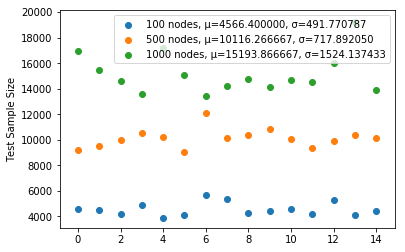

In [137]:
for idx, stat in enumerate(sample_size_stats):
    stat_mean = np.mean(stat)
    stat_std = np.std(stat)
    label = u'%d nodes, μ=%f, σ=%f' % \
            (graph_sizes[idx], stat_mean, stat_std)
    plt.scatter(list(range(number_of_tests)), stat, label=label)

plt.ylabel("Test Sample Size")
plt.legend(loc='best')
plt.show()

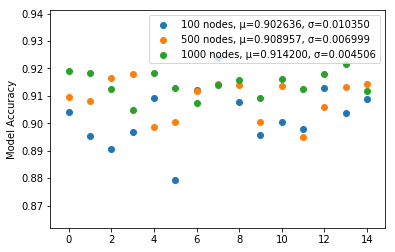

In [136]:
for idx, stat in enumerate(stats):
    stat_mean = np.mean(stat)
    stat_std = np.std(stat)
    label = u'%d nodes, μ=%f, σ=%f' % \
            (graph_sizes[idx], stat_mean, stat_std)
    plt.scatter(list(range(number_of_tests)), stat, label=label)

plt.ylabel("Model Accuracy")
plt.legend(loc='best')
plt.show()

# We evaluate the paths generated by the model

In [148]:
def nn_infer_next_node(G, path, parent, cur_node, src, dst, model):
#     print("In nn_infer_next_node")
    input_vec, x_src, y_src, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    
    real_input_vec = np.append(input_vec[:, :-1].reshape(-1), [x_src, y_src, x_dst, y_dst])
    pred = model.predict(mx.io.NDArrayIter(np.array([real_input_vec]), np.array([0]))).asnumpy()[0]
    pred_idx = np.argmax(pred)
    neighbor = int(input_vec[pred_idx][-1])
    
    if neighbor == -1:
#         print("Invalid prediction, randomizing next node")
        avaliable_neighbors = filter(lambda d: d >= 0, input_vec[:, -1])
        neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
    
#     if neighbor in path:
#         print("Duplicated nodes, randomizing next node")
#         avaliable_neighbors = filter(lambda d: d >= 0 and d != neighbor, input_vec[:, -1])

#         if len(avaliable_neighbors) == 0:
#             print("Duplicated nodes, no other nodes available")
#         else:
#             neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
        
    return (neighbor, G.get_edge_data(cur_node, neighbor)['weight'])

def dijkstra_path_finder(G, src, dst, model=None, invalid_path_threshold=100):
    
    path = [src]
    parent_node = -1
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= invalid_path_threshold:
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, path, parent_node, cur_node, src, dst, model)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        parent_node = cur_node
        cur_node = next_node

In [189]:
G.edges[(0, 89)]

{'centrality': 0.04707070707070707, 'weight': 0.035241105274914225}

In [190]:
def calc_path_weight_sum(G, path):
    
    weight_sum = 0.0
    
    for idx, node in enumerate(path[:-1]):
        weight_sum += G.edges[(node, path[idx + 1])]['weight']
        
    return weight_sum

In [192]:
def calc_statistics(G, pair_path_dict, num_to_test=100):
    found_cnt = 0
    opt_path_cnt = 0
    edge_efficiency = {}
    time_efficiency = {}
    
    def calc_dot_dist(p1, p2):
        return np.dot(p1, p2)

    def calc_geo_dist(p1, p2):

        p_1 = np.array(p1)
        p_2 = np.array(p2)

        return np.sqrt(np.sum((p_1 - p_2)**2))
    
    pairs = pair_path_dict.keys()
    random.shuffle(pairs)
    
    for src, dst in pairs[:num_to_test]:

        nn_path, _, found = dijkstra_path_finder(G, src, dst, model=model, invalid_path_threshold=G.number_of_nodes())
        
        dijkstra_path = pair_path_dict[(src, dst)]
        
        if not found:
            
#             print("The model is unable to find a path between %d and %d" % (src, dst))
            
#             plot_dijkstra_nn_comparison(G, dijkstra_path, nn_path)
            
#             print("Dijkstra path :", dijkstra_path)
# #             print("NN path :", nn_path)
#             print('')
            continue

        found_cnt += 1
        
        edge_efficiency[(src, dst)] = float(len(dijkstra_path)-1) / (len(nn_path)-1)
        time_efficiency[(src, dst)] = calc_path_weight_sum(G, dijkstra_path) \
                                        / calc_path_weight_sum(G, nn_path)
        
        if nn_path == dijkstra_path:
            opt_path_cnt = opt_path_cnt + 1

        else:
            print("The model is able to find a different path between %d and %d" % (src, dst))
            plot_dijkstra_nn_comparison(G, dijkstra_path, nn_path)
            print("Dijkstra path :", dijkstra_path)
            print("NN path :", nn_path)
            print('')

    return found_cnt, opt_path_cnt, edge_efficiency, time_efficiency

In [193]:
def print_paths_statistics(G, pair_path_dict, num_to_test=100):

    num_total_path = num_to_test

    found_cnt, opt_path_cnt, edge_efficiency, time_efficiency = calc_statistics(G, pair_path_dict=pair_path_dict, num_to_test=num_to_test)
    print('%d out of %d can find path: %f' % (found_cnt, num_total_path, float(found_cnt)/num_total_path))
    print('%d out of %d can find optimal path: %f' % (opt_path_cnt, found_cnt, float(opt_path_cnt)/found_cnt))
    print('%d out of %d all paths can find optimal paths: %f' % (opt_path_cnt, num_total_path, float(opt_path_cnt)/num_total_path))
    
    edge_efficiency_values = edge_efficiency.values()
    stat_mean = np.mean(edge_efficiency_values)
    stat_std = np.std(edge_efficiency_values)
    
    label = u'%d pairs, μ=%f, σ=%f' % \
            (len(edge_efficiency), stat_mean, stat_std)
    print(label)
    
    time_efficiency_values = time_efficiency.values()
    stat_mean = np.mean(time_efficiency_values)
    stat_std = np.std(time_efficiency_values)
    
    label = u'%d pairs, μ=%f, σ=%f' % \
            (len(time_efficiency), stat_mean, stat_std)
    print(label)

The model is able to find a different path between 71 and 70


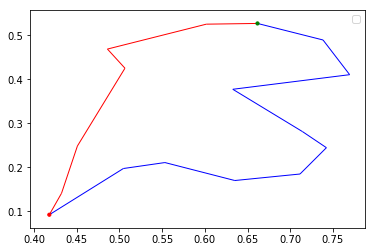

('Dijkstra path :', [71, 94, 78, 59, 20, 74, 70])
('NN path :', [71, 32, 34, 86, 8, 96, 2, 93, 91, 76, 70])

The model is able to find a different path between 67 and 0


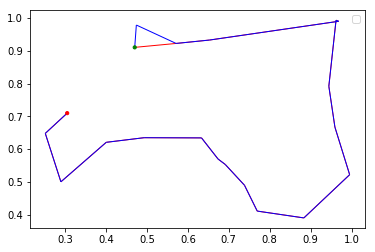

('Dijkstra path :', [67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 0])
('NN path :', [67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 0])

The model is able to find a different path between 67 and 99


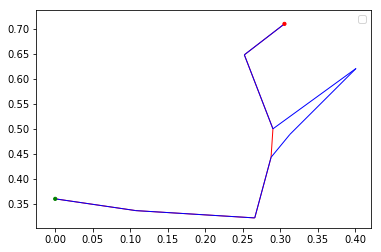

('Dijkstra path :', [67, 79, 1, 30, 42, 15, 99])
('NN path :', [67, 79, 1, 61, 18, 30, 42, 15, 99])



The model is able to find a different path between 2 and 55


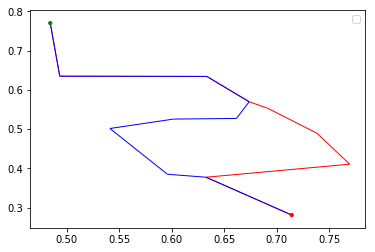

('Dijkstra path :', [2, 93, 91, 76, 46, 82, 24, 3, 55])
('NN path :', [2, 93, 83, 36, 74, 70, 82, 24, 3, 55])

The model is able to find a different path between 65 and 91


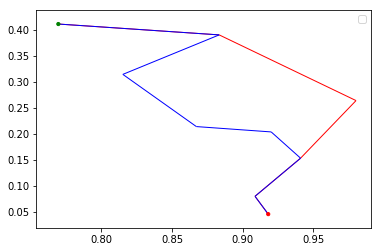

('Dijkstra path :', [65, 43, 17, 19, 41, 91])
('NN path :', [65, 43, 17, 33, 31, 7, 41, 91])

The model is able to find a different path between 14 and 29


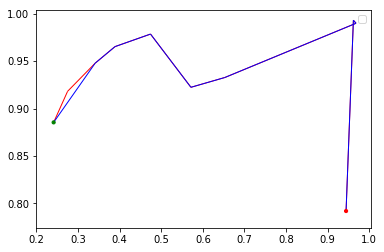

('Dijkstra path :', [14, 13, 37, 56, 53, 69, 40, 38, 39, 29])
('NN path :', [14, 13, 37, 56, 53, 69, 40, 38, 29])

The model is able to find a different path between 6 and 95


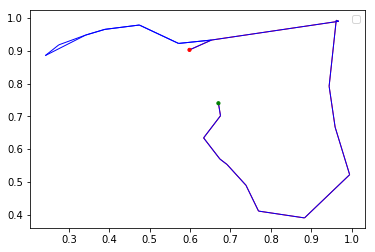

('Dijkstra path :', [6, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 68, 95])
('NN path :', [6, 56, 53, 69, 40, 38, 39, 29, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 68, 95])



The model is able to find a different path between 89 and 81


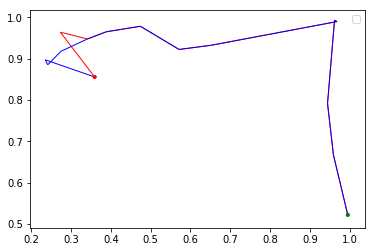

('Dijkstra path :', [89, 98, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81])
('NN path :', [89, 64, 29, 39, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81])

The model is able to find a different path between 48 and 50


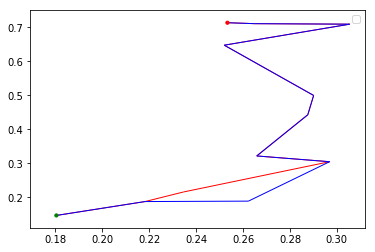

('Dijkstra path :', [48, 23, 67, 79, 1, 30, 42, 47, 11, 97, 50])
('NN path :', [48, 23, 67, 79, 1, 30, 42, 47, 72, 97, 50])

The model is able to find a different path between 4 and 50


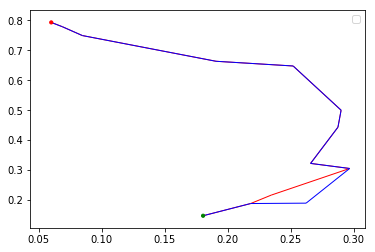

('Dijkstra path :', [4, 21, 51, 54, 79, 1, 30, 42, 47, 11, 97, 50])
('NN path :', [4, 21, 51, 54, 79, 1, 30, 42, 47, 72, 97, 50])

The model is able to find a different path between 82 and 8


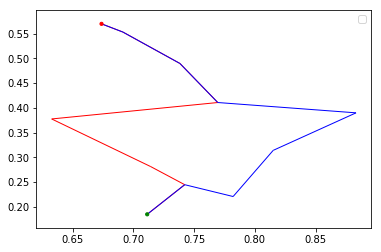

('Dijkstra path :', [82, 46, 76, 91, 93, 2, 96, 8])
('NN path :', [82, 46, 76, 91, 41, 7, 26, 96, 8])

The model is able to find a different path between 53 and 10


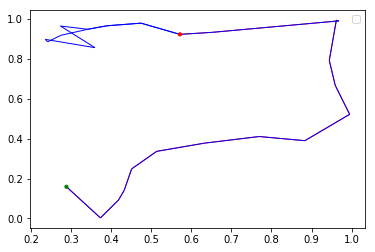

('Dijkstra path :', [53, 56, 37, 13, 14, 52, 81, 41, 91, 93, 25, 78, 94, 71, 80, 10])
('NN path :', [53, 69, 40, 38, 39, 29, 64, 89, 98, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 93, 25, 78, 94, 71, 80, 10])

The model is able to find a different path between 13 and 48


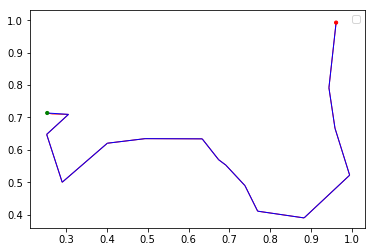

('Dijkstra path :', [13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 1, 79, 67, 23, 48])
('NN path :', [13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 1, 79, 67, 48])

The model is able to find a different path between 16 and 53


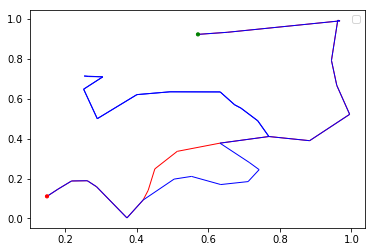

('Dijkstra path :', [16, 50, 97, 72, 10, 80, 71, 94, 78, 25, 93, 91, 41, 81, 52, 14, 13, 37, 56, 53])
('NN path :', [16, 50, 97, 72, 10, 80, 71, 32, 34, 86, 8, 96, 2, 93, 91, 76, 46, 82, 24, 3, 61, 1, 79, 67, 23, 48, 67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53])

The model is able to find a different path between 9 and 46


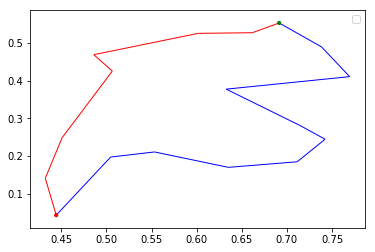

('Dijkstra path :', [9, 94, 78, 59, 20, 74, 70, 46])
('NN path :', [9, 32, 34, 86, 8, 96, 2, 93, 91, 76, 46])

The model is able to find a different path between 95 and 88


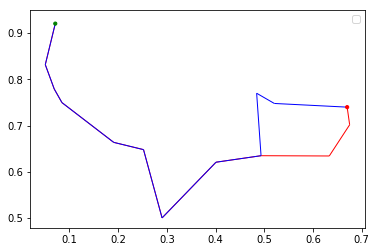

('Dijkstra path :', [95, 68, 24, 3, 61, 1, 79, 54, 51, 21, 44, 88])
('NN path :', [95, 77, 55, 3, 61, 1, 79, 54, 51, 21, 44, 88])



The model is able to find a different path between 66 and 65


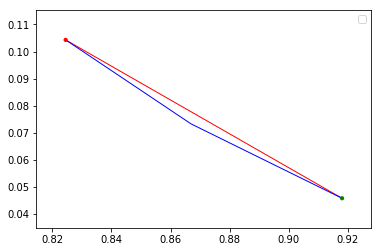

('Dijkstra path :', [66, 65])
('NN path :', [66, 58, 65])

The model is able to find a different path between 66 and 73


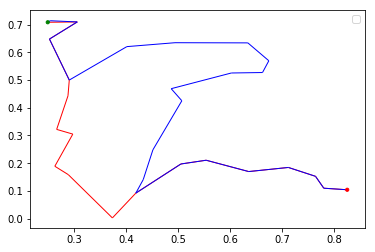

('Dijkstra path :', [66, 27, 85, 8, 86, 34, 32, 71, 80, 10, 72, 47, 42, 30, 1, 79, 67, 73])
('NN path :', [66, 27, 85, 8, 86, 34, 32, 71, 94, 78, 59, 20, 74, 70, 82, 24, 3, 61, 1, 79, 67, 48, 73])

The model is able to find a different path between 12 and 29


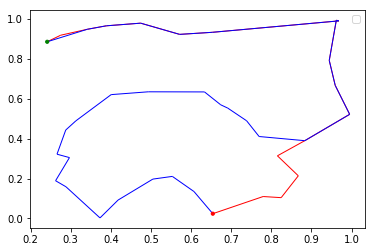

('Dijkstra path :', [12, 27, 66, 31, 7, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 39, 29])
('NN path :', [12, 49, 34, 32, 71, 80, 10, 72, 47, 42, 30, 18, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 29])

The model is able to find a different path between 32 and 11


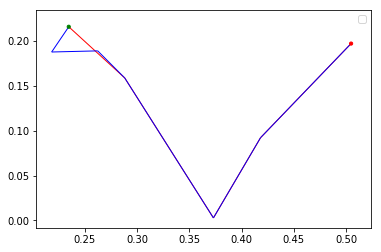

('Dijkstra path :', [32, 71, 80, 10, 11])
('NN path :', [32, 71, 80, 10, 72, 97, 11])

The model is able to find a different path between 23 and 47


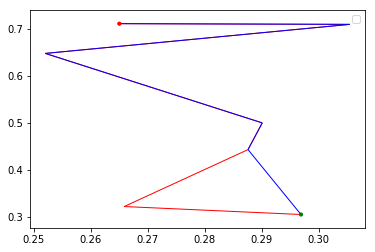

('Dijkstra path :', [23, 67, 79, 1, 30, 42, 47])
('NN path :', [23, 67, 79, 1, 30, 47])

The model is able to find a different path between 76 and 13


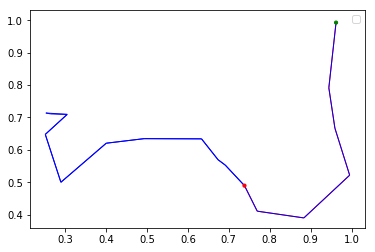

('Dijkstra path :', [76, 91, 41, 81, 52, 14, 13])
('NN path :', [76, 46, 82, 24, 3, 61, 1, 79, 67, 23, 48, 67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13])

The model is able to find a different path between 58 and 98


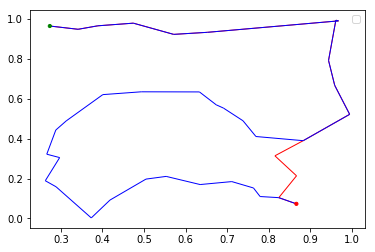

('Dijkstra path :', [58, 66, 31, 7, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 98])
('NN path :', [58, 66, 27, 85, 8, 86, 34, 32, 71, 80, 10, 72, 47, 42, 30, 18, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 98])



The model is able to find a different path between 20 and 56


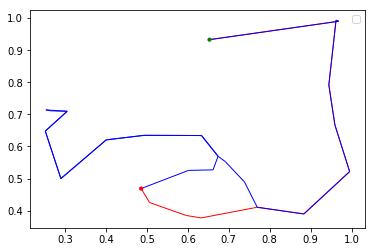

('Dijkstra path :', [20, 59, 83, 93, 91, 41, 81, 52, 14, 13, 37, 56])
('NN path :', [20, 74, 70, 82, 24, 3, 61, 1, 79, 67, 23, 48, 67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56])

The model is able to find a different path between 77 and 51


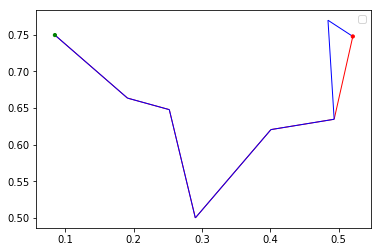

('Dijkstra path :', [77, 3, 61, 1, 79, 54, 51])
('NN path :', [77, 55, 3, 61, 1, 79, 54, 51])

The model is able to find a different path between 57 and 65


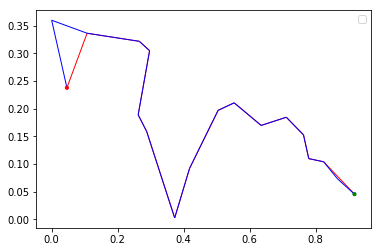

('Dijkstra path :', [57, 15, 42, 47, 72, 10, 80, 71, 32, 34, 86, 8, 85, 27, 66, 65])
('NN path :', [57, 99, 15, 42, 47, 72, 10, 80, 71, 32, 34, 86, 8, 85, 27, 66, 58, 65])



The model is able to find a different path between 50 and 74


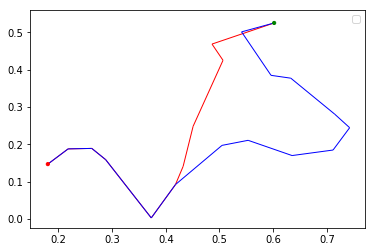

('Dijkstra path :', [50, 97, 72, 10, 80, 71, 94, 78, 59, 20, 74])
('NN path :', [50, 97, 72, 10, 80, 71, 32, 34, 86, 8, 96, 2, 93, 83, 36, 74])

The model is able to find a different path between 25 and 60


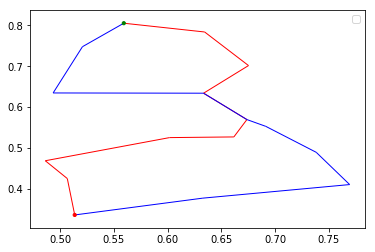

('Dijkstra path :', [25, 59, 20, 74, 70, 82, 24, 68, 5, 60])
('NN path :', [25, 93, 91, 76, 46, 82, 24, 3, 77, 60])



The model is able to find a different path between 89 and 33


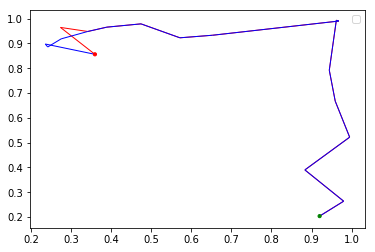

('Dijkstra path :', [89, 98, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 19, 33])
('NN path :', [89, 64, 29, 39, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 19, 33])

The model is able to find a different path between 88 and 49


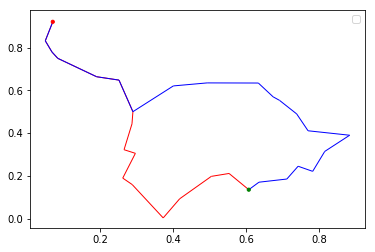

('Dijkstra path :', [88, 44, 21, 51, 54, 79, 1, 30, 42, 47, 72, 10, 80, 71, 32, 34, 49])
('NN path :', [88, 44, 21, 51, 54, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 7, 26, 96, 8, 86, 49])

The model is able to find a different path between 3 and 85


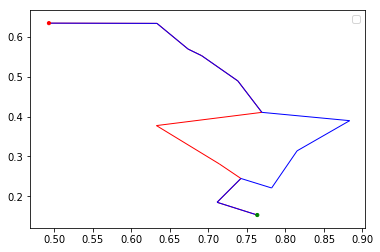

('Dijkstra path :', [3, 24, 82, 46, 76, 91, 93, 2, 96, 8, 85])
('NN path :', [3, 24, 82, 46, 76, 91, 41, 7, 26, 96, 8, 85])



The model is able to find a different path between 83 and 40


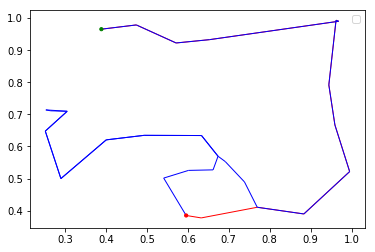

('Dijkstra path :', [83, 93, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40])
('NN path :', [83, 36, 74, 70, 82, 24, 3, 61, 1, 79, 67, 23, 48, 67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40])



The model is able to find a different path between 53 and 16


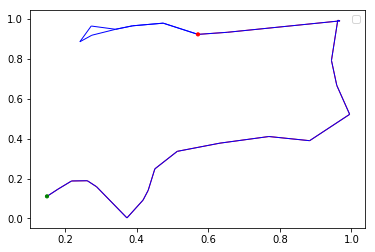

('Dijkstra path :', [53, 56, 37, 13, 14, 52, 81, 41, 91, 93, 25, 78, 94, 71, 80, 10, 72, 97, 50, 16])
('NN path :', [53, 69, 40, 38, 39, 29, 98, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 93, 25, 78, 94, 71, 80, 10, 72, 97, 50, 16])



The model is able to find a different path between 98 and 58


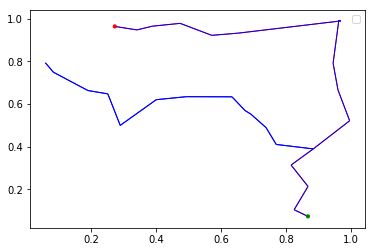

('Dijkstra path :', [98, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 7, 31, 66, 58])
('NN path :', [98, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 1, 79, 54, 51, 21, 4, 51, 54, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 7, 31, 66, 58])

The model is able to find a different path between 36 and 78


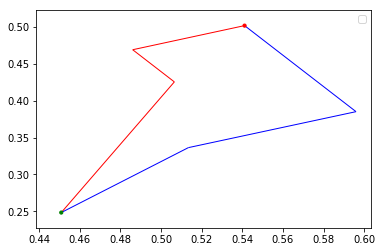

('Dijkstra path :', [36, 20, 59, 78])
('NN path :', [36, 83, 25, 78])



The model is able to find a different path between 10 and 62


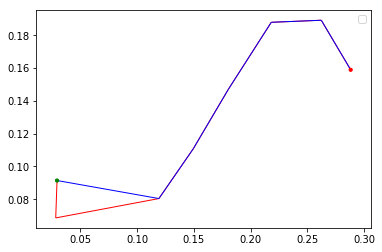

('Dijkstra path :', [10, 72, 97, 50, 16, 84, 92, 62])
('NN path :', [10, 72, 97, 50, 16, 84, 62])

The model is able to find a different path between 37 and 52


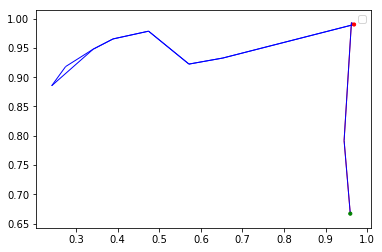

('Dijkstra path :', [37, 13, 14, 52])
('NN path :', [37, 56, 53, 69, 40, 38, 39, 29, 38, 40, 69, 53, 56, 37, 13, 14, 52])

The model is able to find a different path between 16 and 68


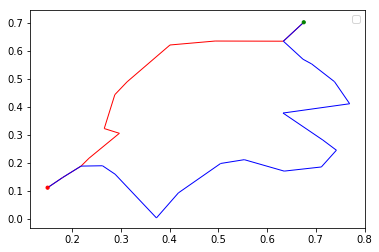

('Dijkstra path :', [16, 50, 97, 11, 47, 42, 30, 18, 61, 3, 24, 68])
('NN path :', [16, 50, 97, 72, 10, 80, 71, 32, 34, 86, 8, 96, 2, 93, 91, 76, 46, 82, 24, 68])



The model is able to find a different path between 21 and 49


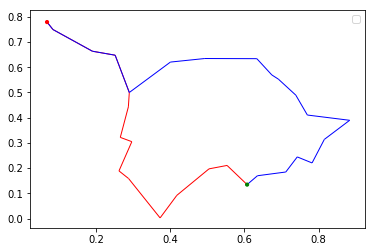

('Dijkstra path :', [21, 51, 54, 79, 1, 30, 42, 47, 72, 10, 80, 71, 32, 34, 49])
('NN path :', [21, 51, 54, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 7, 26, 96, 8, 86, 49])

The model is able to find a different path between 63 and 11


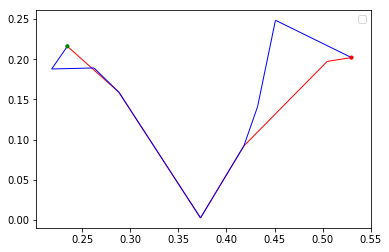

('Dijkstra path :', [63, 32, 71, 80, 10, 11])
('NN path :', [63, 78, 94, 71, 80, 10, 72, 97, 11])



The model is able to find a different path between 89 and 28


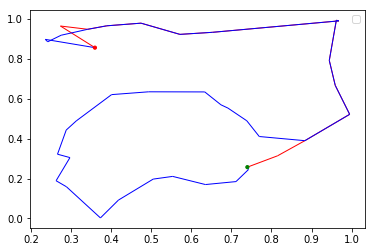

('Dijkstra path :', [89, 98, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 7, 28])
('NN path :', [89, 64, 29, 39, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 18, 30, 42, 47, 72, 10, 80, 71, 32, 34, 86, 8, 96, 28])

The model is able to find a different path between 11 and 32


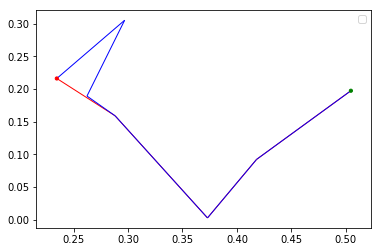

('Dijkstra path :', [11, 10, 80, 71, 32])
('NN path :', [11, 47, 72, 10, 80, 71, 32])

The model is able to find a different path between 5 and 52


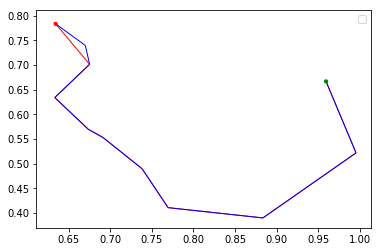

('Dijkstra path :', [5, 68, 24, 82, 46, 76, 91, 41, 81, 52])
('NN path :', [5, 95, 68, 24, 82, 46, 76, 91, 41, 81, 52])

The model is able to find a different path between 33 and 77


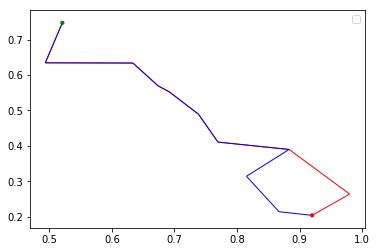

('Dijkstra path :', [33, 19, 41, 91, 76, 46, 82, 24, 3, 77])
('NN path :', [33, 31, 7, 41, 91, 76, 46, 82, 24, 3, 77])

The model is able to find a different path between 65 and 57


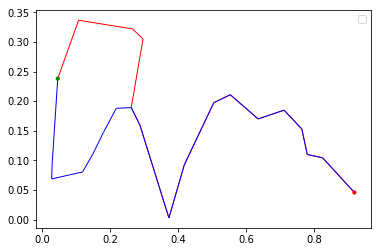

('Dijkstra path :', [65, 66, 27, 85, 8, 86, 34, 32, 71, 80, 10, 72, 47, 42, 15, 57])
('NN path :', [65, 66, 27, 85, 8, 86, 34, 32, 71, 80, 10, 72, 97, 50, 16, 84, 92, 62, 57])

The model is able to find a different path between 19 and 74


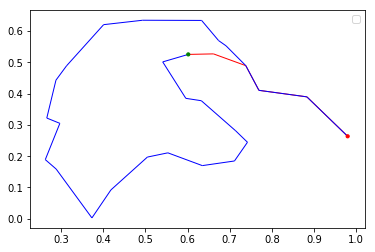

('Dijkstra path :', [19, 41, 91, 76, 70, 74])
('NN path :', [19, 41, 91, 76, 46, 82, 24, 3, 61, 18, 30, 42, 47, 72, 10, 80, 71, 32, 34, 86, 8, 96, 2, 93, 83, 36, 74])

The model is able to find a different path between 72 and 14


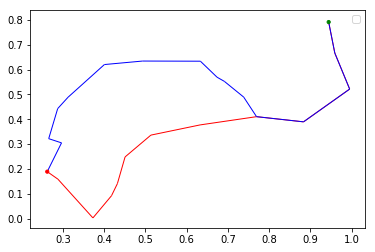

('Dijkstra path :', [72, 10, 80, 71, 94, 78, 25, 93, 91, 41, 81, 52, 14])
('NN path :', [72, 47, 42, 30, 18, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14])



The model is able to find a different path between 64 and 34


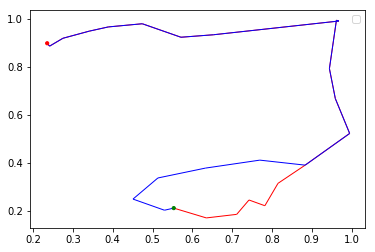

('Dijkstra path :', [64, 29, 39, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 7, 26, 96, 8, 86, 34])
('NN path :', [64, 29, 39, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 93, 25, 78, 63, 34])



The model is able to find a different path between 55 and 50


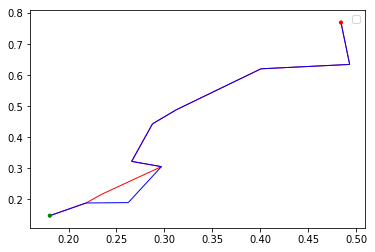

('Dijkstra path :', [55, 3, 61, 18, 30, 42, 47, 11, 97, 50])
('NN path :', [55, 3, 61, 18, 30, 42, 47, 72, 97, 50])

The model is able to find a different path between 33 and 18


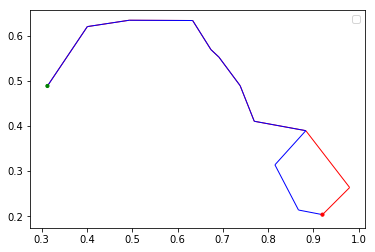

('Dijkstra path :', [33, 19, 41, 91, 76, 46, 82, 24, 3, 61, 18])
('NN path :', [33, 31, 7, 41, 91, 76, 46, 82, 24, 3, 61, 18])

The model is able to find a different path between 9 and 17


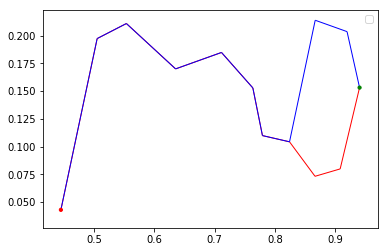

('Dijkstra path :', [9, 32, 34, 86, 8, 85, 27, 66, 58, 43, 17])
('NN path :', [9, 32, 34, 86, 8, 85, 27, 66, 31, 33, 17])

The model is able to find a different path between 85 and 37


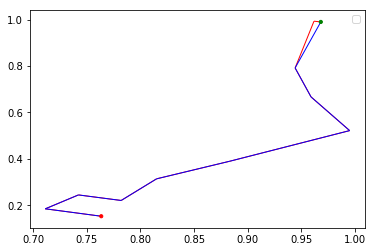

('Dijkstra path :', [85, 8, 96, 26, 7, 41, 81, 52, 14, 13, 37])
('NN path :', [85, 8, 96, 26, 7, 41, 81, 52, 14, 37])

The model is able to find a different path between 33 and 70


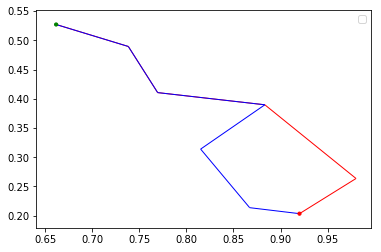

('Dijkstra path :', [33, 19, 41, 91, 76, 70])
('NN path :', [33, 31, 7, 41, 91, 76, 70])

The model is able to find a different path between 43 and 39


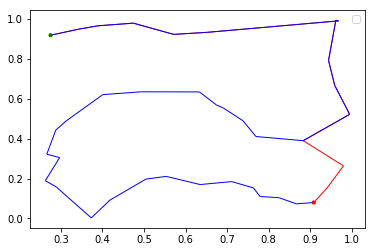

('Dijkstra path :', [43, 17, 19, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 39])
('NN path :', [43, 58, 66, 27, 85, 8, 86, 34, 32, 71, 80, 10, 72, 47, 42, 30, 18, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 39])



The model is able to find a different path between 56 and 20


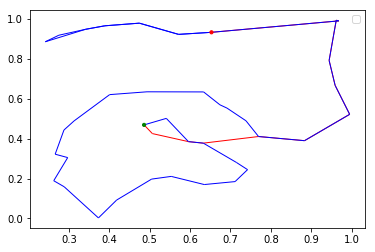

('Dijkstra path :', [56, 37, 13, 14, 52, 81, 41, 91, 93, 83, 59, 20])
('NN path :', [56, 53, 69, 40, 38, 39, 29, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 18, 30, 42, 47, 72, 10, 80, 71, 32, 34, 86, 8, 96, 2, 93, 83, 36, 20])



The model is able to find a different path between 37 and 53


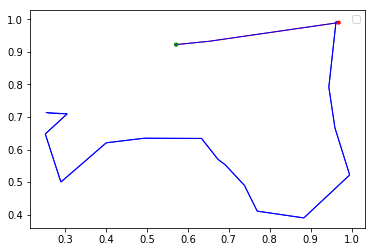

('Dijkstra path :', [37, 56, 53])
('NN path :', [37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 1, 79, 67, 23, 48, 67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53])

The model is able to find a different path between 41 and 27


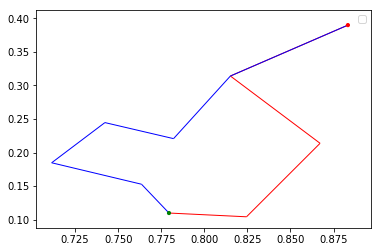

('Dijkstra path :', [41, 7, 31, 66, 27])
('NN path :', [41, 7, 26, 96, 8, 85, 27])

The model is able to find a different path between 95 and 78


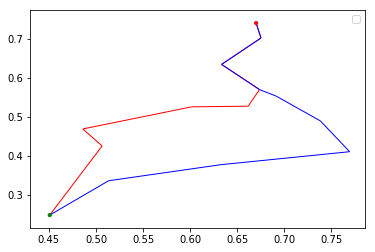

('Dijkstra path :', [95, 68, 24, 82, 70, 74, 20, 59, 78])
('NN path :', [95, 68, 24, 82, 46, 76, 91, 93, 25, 78])

The model is able to find a different path between 27 and 14


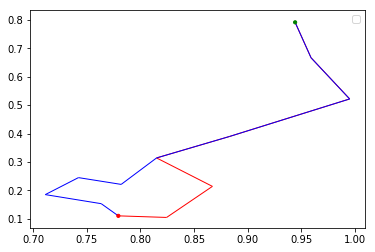

('Dijkstra path :', [27, 66, 31, 7, 41, 81, 52, 14])
('NN path :', [27, 85, 8, 96, 26, 7, 41, 81, 52, 14])

The model is able to find a different path between 44 and 25


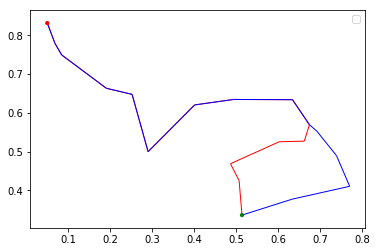

('Dijkstra path :', [44, 21, 51, 54, 79, 1, 61, 3, 24, 82, 70, 74, 20, 59, 25])
('NN path :', [44, 21, 51, 54, 79, 1, 61, 3, 24, 82, 46, 76, 91, 93, 25])



The model is able to find a different path between 47 and 50


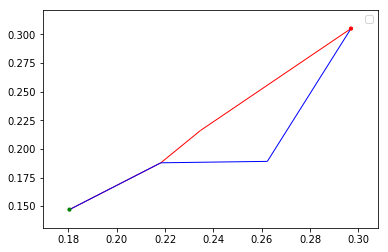

('Dijkstra path :', [47, 11, 97, 50])
('NN path :', [47, 72, 97, 50])



The model is able to find a different path between 41 and 56


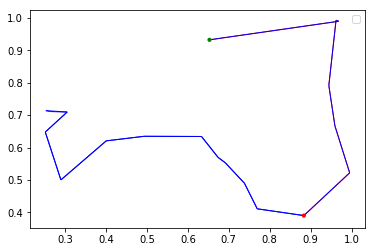

('Dijkstra path :', [41, 81, 52, 14, 13, 37, 56])
('NN path :', [41, 91, 76, 46, 82, 24, 3, 61, 1, 79, 67, 23, 48, 67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56])



The model is able to find a different path between 16 and 0


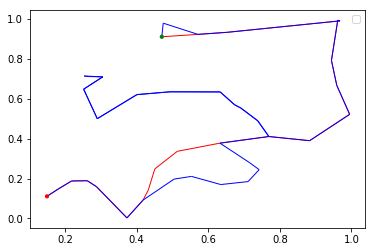

('Dijkstra path :', [16, 50, 97, 72, 10, 80, 71, 94, 78, 25, 93, 91, 41, 81, 52, 14, 13, 37, 56, 53, 0])
('NN path :', [16, 50, 97, 72, 10, 80, 71, 32, 34, 86, 8, 96, 2, 93, 91, 76, 46, 82, 24, 3, 61, 1, 79, 67, 23, 48, 67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 0])

The model is able to find a different path between 1 and 8


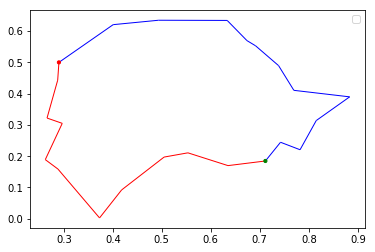

('Dijkstra path :', [1, 30, 42, 47, 72, 10, 80, 71, 32, 34, 86, 8])
('NN path :', [1, 61, 3, 24, 82, 46, 76, 91, 41, 7, 26, 96, 8])

The model is able to find a different path between 85 and 9


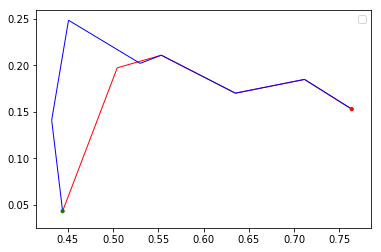

('Dijkstra path :', [85, 8, 86, 34, 32, 9])
('NN path :', [85, 8, 86, 34, 63, 78, 94, 9])



The model is able to find a different path between 66 and 83


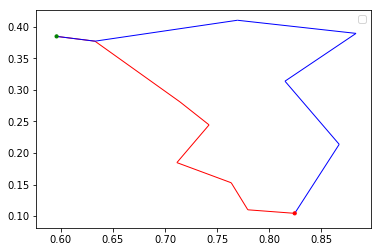

('Dijkstra path :', [66, 27, 85, 8, 96, 2, 93, 83])
('NN path :', [66, 31, 7, 41, 91, 93, 83])

The model is able to find a different path between 6 and 28


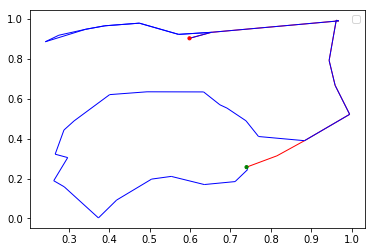

('Dijkstra path :', [6, 56, 37, 13, 14, 52, 81, 41, 7, 28])
('NN path :', [6, 56, 53, 69, 40, 38, 39, 29, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 18, 30, 42, 47, 72, 10, 80, 71, 32, 34, 86, 8, 96, 28])



The model is able to find a different path between 76 and 40


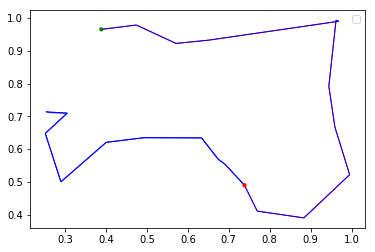

('Dijkstra path :', [76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40])
('NN path :', [76, 46, 82, 24, 3, 61, 1, 79, 67, 23, 48, 67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40])

The model is able to find a different path between 1 and 99


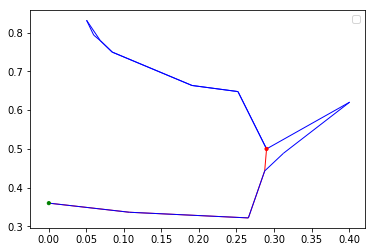

('Dijkstra path :', [1, 30, 42, 15, 99])
('NN path :', [1, 79, 54, 51, 21, 44, 4, 21, 51, 54, 79, 1, 61, 18, 30, 42, 15, 99])



The model is able to find a different path between 47 and 19


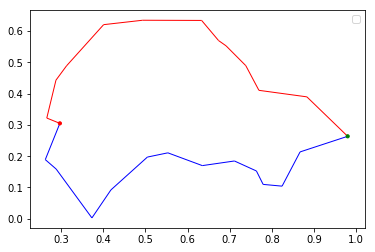

('Dijkstra path :', [47, 42, 30, 18, 61, 3, 24, 82, 46, 76, 91, 41, 19])
('NN path :', [47, 72, 10, 80, 71, 32, 34, 86, 8, 85, 27, 66, 31, 19])



The model is able to find a different path between 30 and 29


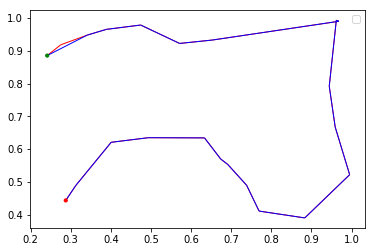

('Dijkstra path :', [30, 18, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 39, 29])
('NN path :', [30, 18, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 29])

The model is able to find a different path between 99 and 1


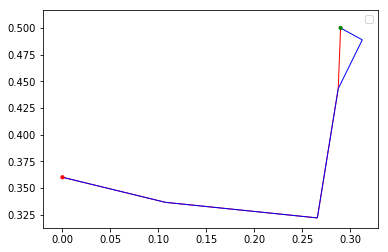

('Dijkstra path :', [99, 15, 42, 30, 1])
('NN path :', [99, 15, 42, 30, 18, 1])

The model is able to find a different path between 46 and 9


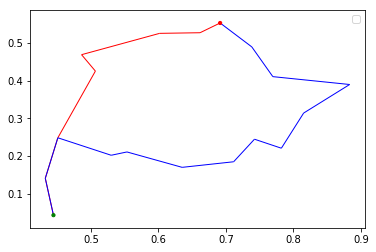

('Dijkstra path :', [46, 70, 74, 20, 59, 78, 94, 9])
('NN path :', [46, 76, 91, 41, 7, 26, 96, 8, 86, 34, 63, 78, 94, 9])



The model is able to find a different path between 51 and 77


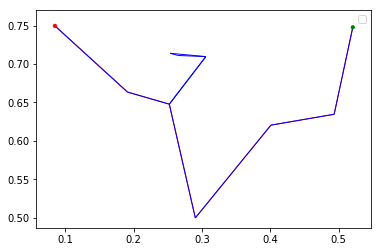

('Dijkstra path :', [51, 54, 79, 1, 61, 3, 77])
('NN path :', [51, 54, 79, 67, 23, 48, 67, 79, 1, 61, 3, 77])



The model is able to find a different path between 42 and 97


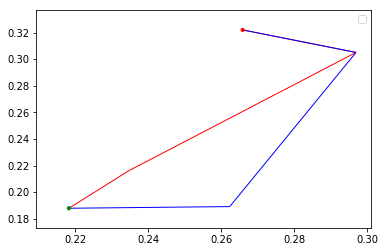

('Dijkstra path :', [42, 47, 11, 97])
('NN path :', [42, 47, 72, 97])

The model is able to find a different path between 35 and 32


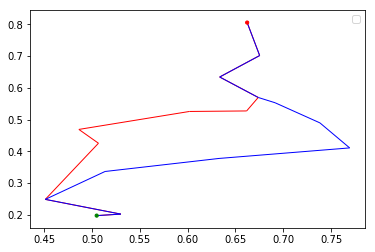

('Dijkstra path :', [35, 68, 24, 82, 70, 74, 20, 59, 78, 63, 32])
('NN path :', [35, 68, 24, 82, 46, 76, 91, 93, 25, 78, 63, 32])

The model is able to find a different path between 84 and 25


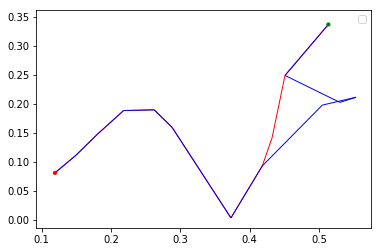

('Dijkstra path :', [84, 16, 50, 97, 72, 10, 80, 71, 94, 78, 25])
('NN path :', [84, 16, 50, 97, 72, 10, 80, 71, 32, 34, 63, 78, 25])

The model is able to find a different path between 12 and 46


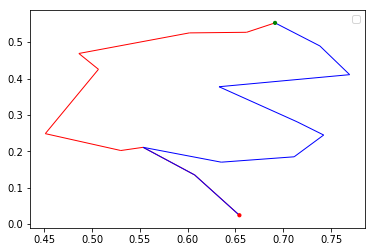

('Dijkstra path :', [12, 49, 34, 63, 78, 59, 20, 74, 70, 46])
('NN path :', [12, 49, 34, 86, 8, 96, 2, 93, 91, 76, 46])



The model is able to find a different path between 30 and 78


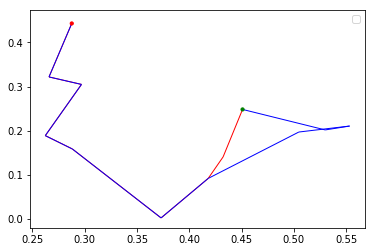

('Dijkstra path :', [30, 42, 47, 72, 10, 80, 71, 94, 78])
('NN path :', [30, 42, 47, 72, 10, 80, 71, 32, 34, 63, 78])



The model is able to find a different path between 3 and 22


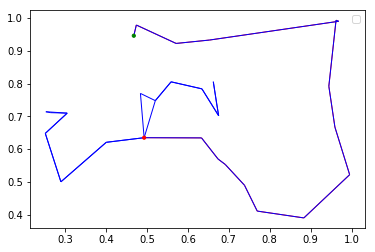

('Dijkstra path :', [3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 22])
('NN path :', [3, 77, 60, 5, 68, 95, 35, 68, 5, 60, 77, 55, 3, 61, 1, 79, 67, 23, 48, 67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 22])



The model is able to find a different path between 47 and 34


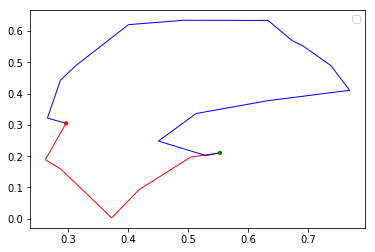

('Dijkstra path :', [47, 72, 10, 80, 71, 32, 34])
('NN path :', [47, 42, 30, 18, 61, 3, 24, 82, 46, 76, 91, 93, 25, 78, 63, 34])



The model is able to find a different path between 35 and 22


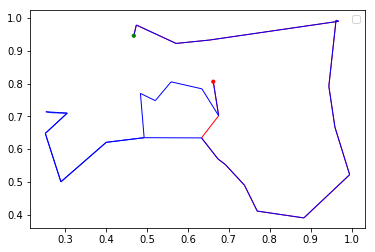

('Dijkstra path :', [35, 68, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 22])
('NN path :', [35, 68, 5, 60, 77, 55, 3, 61, 1, 79, 67, 23, 48, 67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 22])



The model is able to find a different path between 83 and 66


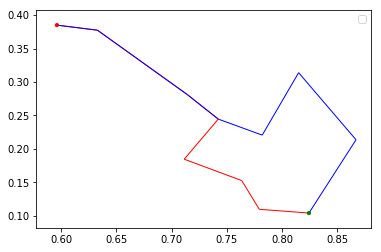

('Dijkstra path :', [83, 93, 2, 96, 8, 85, 27, 66])
('NN path :', [83, 93, 2, 96, 26, 7, 31, 66])

The model is able to find a different path between 22 and 3


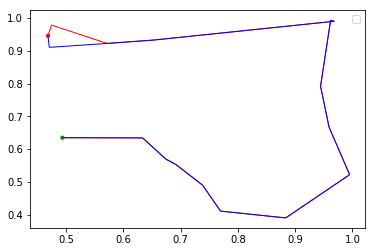

('Dijkstra path :', [22, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3])
('NN path :', [22, 0, 53, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3])



The model is able to find a different path between 2 and 16


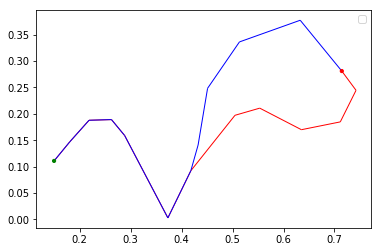

('Dijkstra path :', [2, 96, 8, 86, 34, 32, 71, 80, 10, 72, 97, 50, 16])
('NN path :', [2, 93, 25, 78, 94, 71, 80, 10, 72, 97, 50, 16])



The model is able to find a different path between 68 and 80


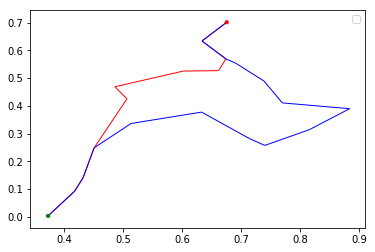

('Dijkstra path :', [68, 24, 82, 70, 74, 20, 59, 78, 94, 71, 80])
('NN path :', [68, 24, 82, 46, 76, 91, 41, 7, 28, 2, 93, 25, 78, 94, 71, 80])

The model is able to find a different path between 69 and 72


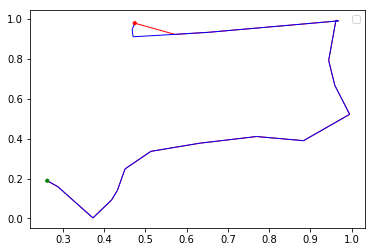

('Dijkstra path :', [69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 93, 25, 78, 94, 71, 80, 10, 72])
('NN path :', [69, 22, 0, 53, 56, 37, 13, 14, 52, 81, 41, 91, 93, 25, 78, 94, 71, 80, 10, 72])



The model is able to find a different path between 74 and 2


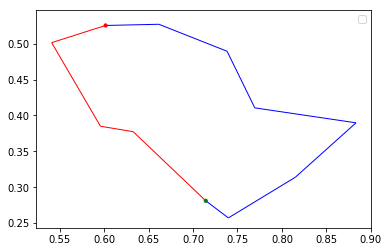

('Dijkstra path :', [74, 36, 83, 93, 2])
('NN path :', [74, 70, 76, 91, 41, 7, 28, 2])



The model is able to find a different path between 63 and 62


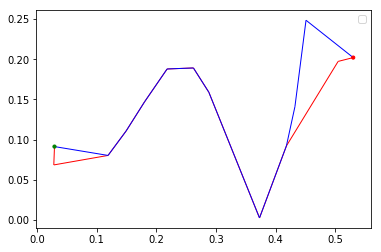

('Dijkstra path :', [63, 32, 71, 80, 10, 72, 97, 50, 16, 84, 92, 62])
('NN path :', [63, 78, 94, 71, 80, 10, 72, 97, 50, 16, 84, 62])



The model is able to find a different path between 85 and 3


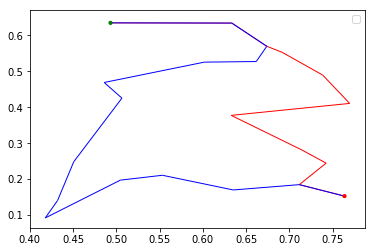

('Dijkstra path :', [85, 8, 96, 2, 93, 91, 76, 46, 82, 24, 3])
('NN path :', [85, 8, 86, 34, 32, 71, 94, 78, 59, 20, 74, 70, 82, 24, 3])

The model is able to find a different path between 27 and 41


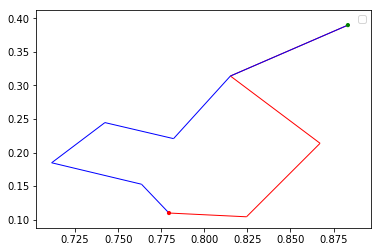

('Dijkstra path :', [27, 66, 31, 7, 41])
('NN path :', [27, 85, 8, 96, 26, 7, 41])

The model is able to find a different path between 30 and 60


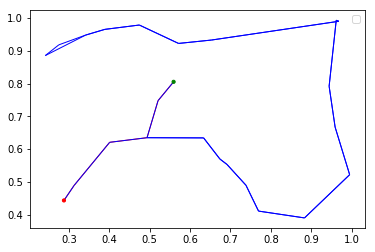

('Dijkstra path :', [30, 18, 61, 3, 77, 60])
('NN path :', [30, 18, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 39, 29, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 77, 60])



The model is able to find a different path between 49 and 54


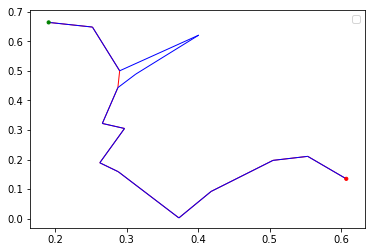

('Dijkstra path :', [49, 34, 32, 71, 80, 10, 72, 47, 42, 30, 1, 79, 54])
('NN path :', [49, 34, 32, 71, 80, 10, 72, 47, 42, 30, 18, 61, 1, 79, 54])

The model is able to find a different path between 14 and 27


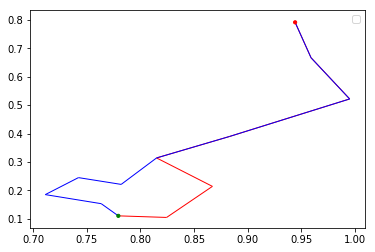

('Dijkstra path :', [14, 52, 81, 41, 7, 31, 66, 27])
('NN path :', [14, 52, 81, 41, 7, 26, 96, 8, 85, 27])

The model is able to find a different path between 72 and 69


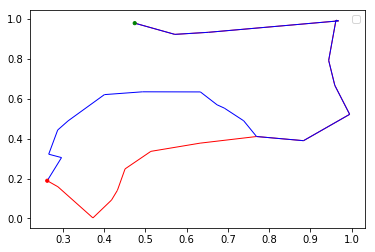

('Dijkstra path :', [72, 10, 80, 71, 94, 78, 25, 93, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69])
('NN path :', [72, 47, 42, 30, 18, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69])



The model is able to find a different path between 87 and 95


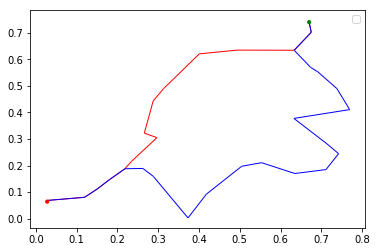

('Dijkstra path :', [87, 92, 84, 16, 50, 97, 11, 47, 42, 30, 18, 61, 3, 24, 68, 95])
('NN path :', [87, 92, 84, 16, 50, 97, 72, 10, 80, 71, 32, 34, 86, 8, 96, 2, 93, 91, 76, 46, 82, 24, 68, 95])

The model is able to find a different path between 55 and 2


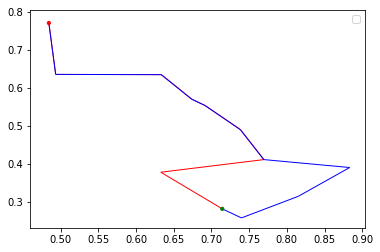

('Dijkstra path :', [55, 3, 24, 82, 46, 76, 91, 93, 2])
('NN path :', [55, 3, 24, 82, 46, 76, 91, 41, 7, 28, 2])



The model is able to find a different path between 52 and 37


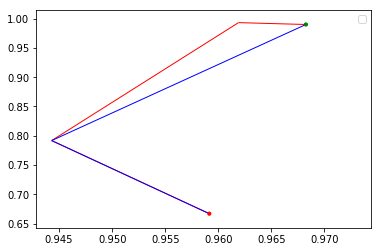

('Dijkstra path :', [52, 14, 13, 37])
('NN path :', [52, 14, 37])

The model is able to find a different path between 49 and 35


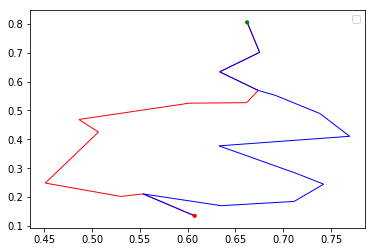

('Dijkstra path :', [49, 34, 63, 78, 59, 20, 74, 70, 82, 24, 68, 35])
('NN path :', [49, 34, 86, 8, 96, 2, 93, 91, 76, 46, 82, 24, 68, 35])



The model is able to find a different path between 97 and 78


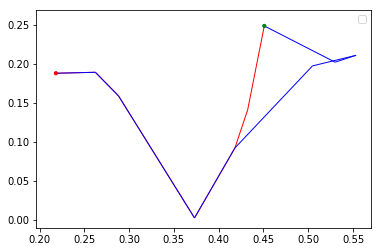

('Dijkstra path :', [97, 72, 10, 80, 71, 94, 78])
('NN path :', [97, 72, 10, 80, 71, 32, 34, 63, 78])

The model is able to find a different path between 11 and 63


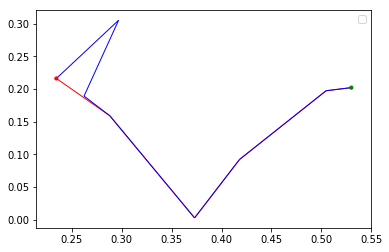

('Dijkstra path :', [11, 10, 80, 71, 32, 63])
('NN path :', [11, 47, 72, 10, 80, 71, 32, 63])

The model is able to find a different path between 16 and 81


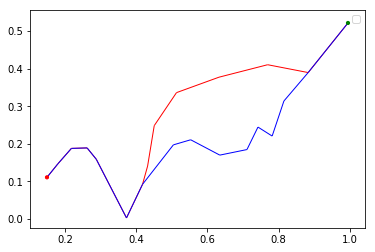

('Dijkstra path :', [16, 50, 97, 72, 10, 80, 71, 94, 78, 25, 93, 91, 41, 81])
('NN path :', [16, 50, 97, 72, 10, 80, 71, 32, 34, 86, 8, 96, 26, 7, 41, 81])

The model is able to find a different path between 62 and 63


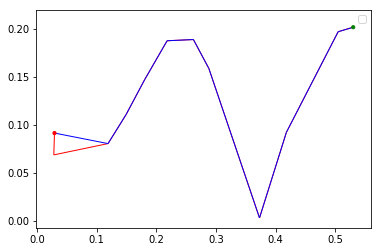

('Dijkstra path :', [62, 92, 84, 16, 50, 97, 72, 10, 80, 71, 32, 63])
('NN path :', [62, 84, 16, 50, 97, 72, 10, 80, 71, 32, 63])

The model is able to find a different path between 8 and 59


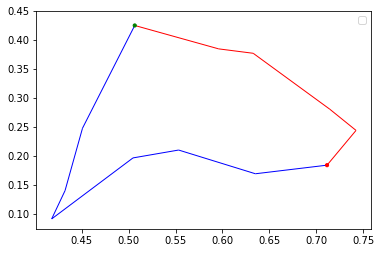

('Dijkstra path :', [8, 96, 2, 93, 83, 59])
('NN path :', [8, 86, 34, 32, 71, 94, 78, 59])

The model is able to find a different path between 73 and 66


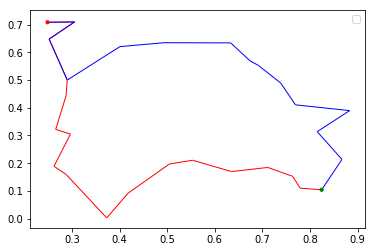

('Dijkstra path :', [73, 67, 79, 1, 30, 42, 47, 72, 10, 80, 71, 32, 34, 86, 8, 85, 27, 66])
('NN path :', [73, 67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 7, 31, 66])

The model is able to find a different path between 47 and 25


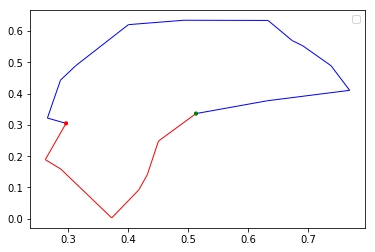

('Dijkstra path :', [47, 72, 10, 80, 71, 94, 78, 25])
('NN path :', [47, 42, 30, 18, 61, 3, 24, 82, 46, 76, 91, 93, 25])

The model is able to find a different path between 65 and 29


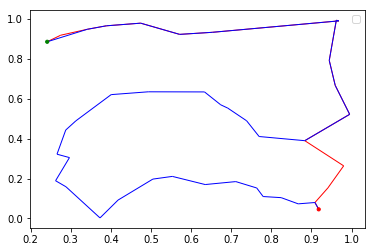

('Dijkstra path :', [65, 43, 17, 19, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 39, 29])
('NN path :', [65, 43, 58, 66, 27, 85, 8, 86, 34, 32, 71, 80, 10, 72, 47, 42, 30, 18, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 29])

The model is able to find a different path between 32 and 35


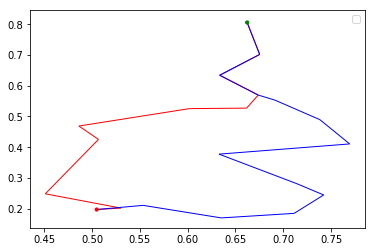

('Dijkstra path :', [32, 63, 78, 59, 20, 74, 70, 82, 24, 68, 35])
('NN path :', [32, 34, 86, 8, 96, 2, 93, 91, 76, 46, 82, 24, 68, 35])



The model is able to find a different path between 38 and 28


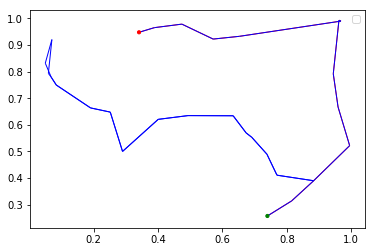

('Dijkstra path :', [38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 7, 28])
('NN path :', [38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 1, 79, 54, 51, 21, 44, 88, 4, 21, 51, 54, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 7, 28])

The model is able to find a different path between 37 and 85


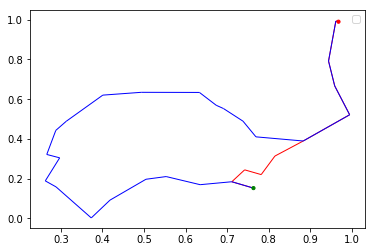

('Dijkstra path :', [37, 13, 14, 52, 81, 41, 7, 26, 96, 8, 85])
('NN path :', [37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 18, 30, 42, 47, 72, 10, 80, 71, 32, 34, 86, 8, 85])



The model is able to find a different path between 29 and 12


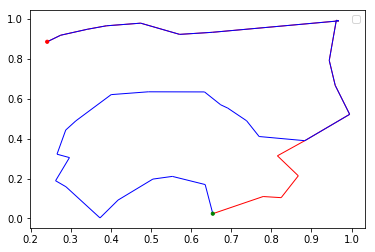

('Dijkstra path :', [29, 39, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 7, 31, 66, 27, 12])
('NN path :', [29, 39, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 18, 30, 42, 47, 72, 10, 80, 71, 32, 34, 86, 12])



The model is able to find a different path between 22 and 75


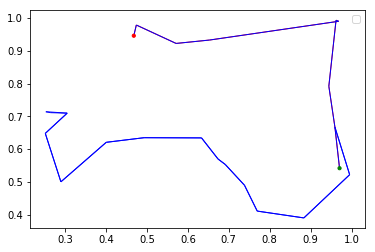

('Dijkstra path :', [22, 69, 53, 56, 37, 13, 14, 52, 75])
('NN path :', [22, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 1, 79, 67, 23, 48, 67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 75])



The model is able to find a different path between 77 and 88


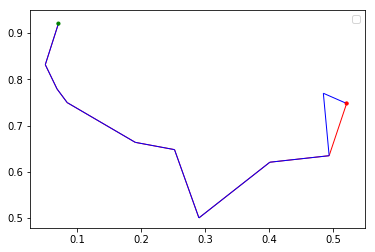

('Dijkstra path :', [77, 3, 61, 1, 79, 54, 51, 21, 44, 88])
('NN path :', [77, 55, 3, 61, 1, 79, 54, 51, 21, 44, 88])



The model is able to find a different path between 16 and 36


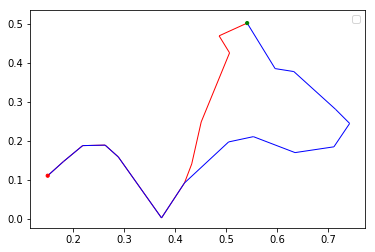

('Dijkstra path :', [16, 50, 97, 72, 10, 80, 71, 94, 78, 59, 20, 36])
('NN path :', [16, 50, 97, 72, 10, 80, 71, 32, 34, 86, 8, 96, 2, 93, 83, 36])



The model is able to find a different path between 59 and 8


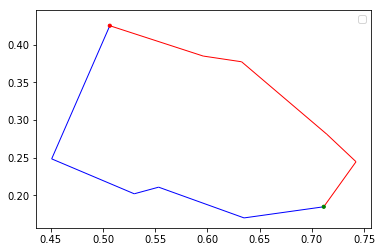

('Dijkstra path :', [59, 83, 93, 2, 96, 8])
('NN path :', [59, 78, 63, 34, 86, 8])

The model is able to find a different path between 37 and 4


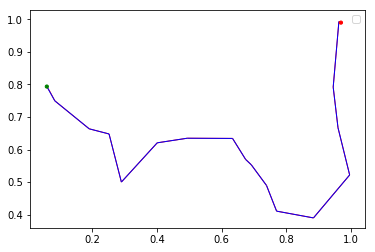

('Dijkstra path :', [37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 1, 79, 54, 51, 21, 4])
('NN path :', [37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 1, 79, 54, 51, 4])



The model is able to find a different path between 90 and 25


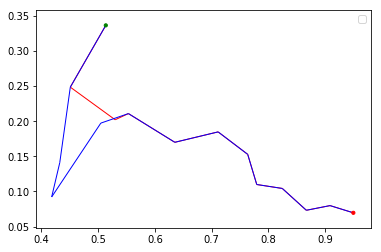

('Dijkstra path :', [90, 43, 58, 66, 27, 85, 8, 86, 34, 63, 78, 25])
('NN path :', [90, 43, 58, 66, 27, 85, 8, 86, 34, 32, 71, 94, 78, 25])

The model is able to find a different path between 49 and 63


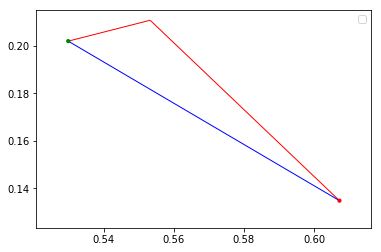

('Dijkstra path :', [49, 34, 63])
('NN path :', [49, 63])

The model is able to find a different path between 25 and 7


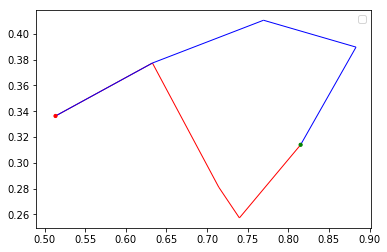

('Dijkstra path :', [25, 93, 2, 28, 7])
('NN path :', [25, 93, 91, 41, 7])

The model is able to find a different path between 11 and 72


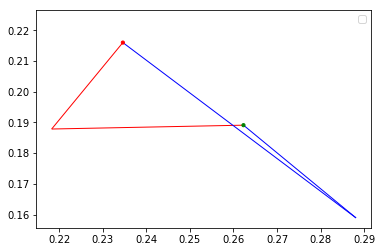

('Dijkstra path :', [11, 97, 72])
('NN path :', [11, 10, 72])

The model is able to find a different path between 0 and 8


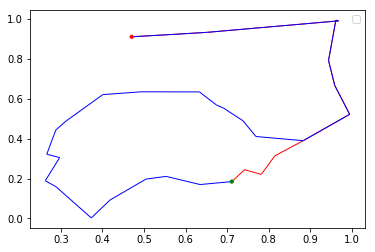

('Dijkstra path :', [0, 53, 56, 37, 13, 14, 52, 81, 41, 7, 26, 96, 8])
('NN path :', [0, 53, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 3, 61, 18, 30, 42, 47, 72, 10, 80, 71, 32, 34, 86, 8])



The model is able to find a different path between 60 and 25


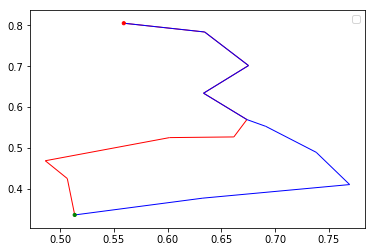

('Dijkstra path :', [60, 5, 68, 24, 82, 70, 74, 20, 59, 25])
('NN path :', [60, 5, 68, 24, 82, 46, 76, 91, 93, 25])

The model is able to find a different path between 78 and 95


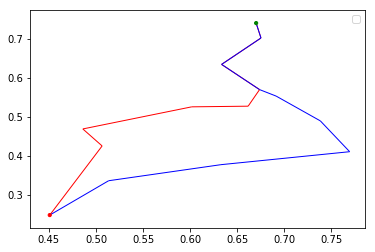

('Dijkstra path :', [78, 59, 20, 74, 70, 82, 24, 68, 95])
('NN path :', [78, 25, 93, 91, 76, 46, 82, 24, 68, 95])

The model is able to find a different path between 77 and 48


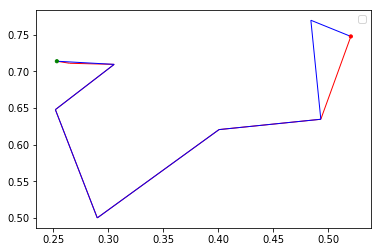

('Dijkstra path :', [77, 3, 61, 1, 79, 67, 23, 48])
('NN path :', [77, 55, 3, 61, 1, 79, 67, 48])

The model is able to find a different path between 50 and 55


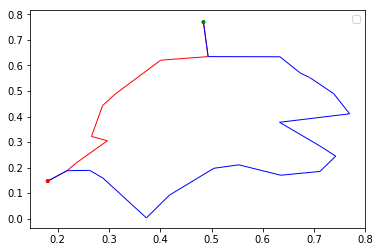

('Dijkstra path :', [50, 97, 11, 47, 42, 30, 18, 61, 3, 55])
('NN path :', [50, 97, 72, 10, 80, 71, 32, 34, 86, 8, 96, 2, 93, 91, 76, 46, 82, 24, 3, 55])



The model is able to find a different path between 88 and 77


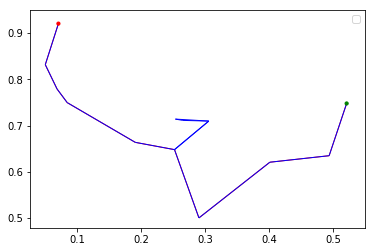

('Dijkstra path :', [88, 44, 21, 51, 54, 79, 1, 61, 3, 77])
('NN path :', [88, 44, 21, 51, 54, 79, 67, 23, 48, 67, 79, 1, 61, 3, 77])

The model is able to find a different path between 88 and 23


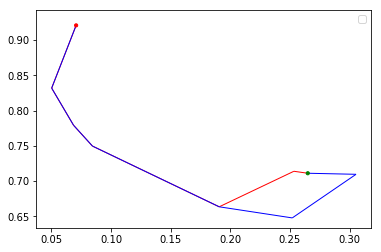

('Dijkstra path :', [88, 44, 21, 51, 54, 48, 23])
('NN path :', [88, 44, 21, 51, 54, 79, 67, 23])

The model is able to find a different path between 95 and 87


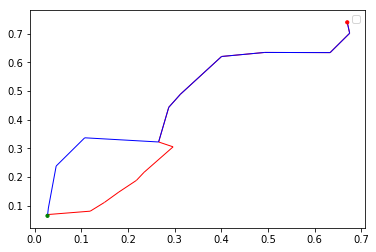

('Dijkstra path :', [95, 68, 24, 3, 61, 18, 30, 42, 47, 11, 97, 50, 16, 84, 92, 87])
('NN path :', [95, 68, 24, 3, 61, 18, 30, 42, 15, 57, 62, 87])

The model is able to find a different path between 58 and 64


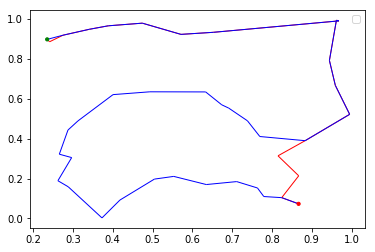

('Dijkstra path :', [58, 66, 31, 7, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 39, 29, 64])
('NN path :', [58, 66, 27, 85, 8, 86, 34, 32, 71, 80, 10, 72, 47, 42, 30, 18, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 39, 64])

The model is able to find a different path between 6 and 63


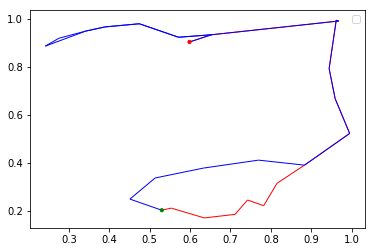

('Dijkstra path :', [6, 56, 37, 13, 14, 52, 81, 41, 7, 26, 96, 8, 86, 34, 63])
('NN path :', [6, 56, 53, 69, 40, 38, 39, 29, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 93, 25, 78, 63])

The model is able to find a different path between 46 and 12


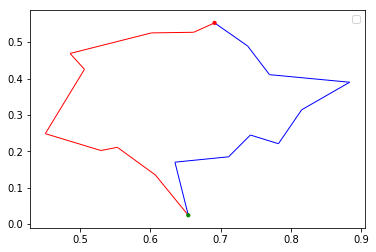

('Dijkstra path :', [46, 70, 74, 20, 59, 78, 63, 34, 49, 12])
('NN path :', [46, 76, 91, 41, 7, 26, 96, 8, 86, 12])

The model is able to find a different path between 60 and 49


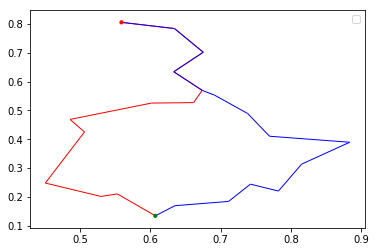

('Dijkstra path :', [60, 5, 68, 24, 82, 70, 74, 20, 59, 78, 63, 34, 49])
('NN path :', [60, 5, 68, 24, 82, 46, 76, 91, 41, 7, 26, 96, 8, 86, 49])

The model is able to find a different path between 17 and 24


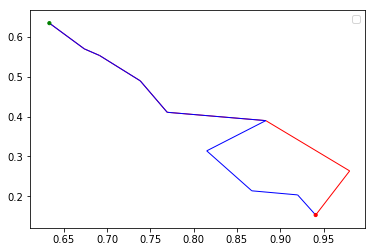

('Dijkstra path :', [17, 19, 41, 91, 76, 46, 82, 24])
('NN path :', [17, 33, 31, 7, 41, 91, 76, 46, 82, 24])



The model is able to find a different path between 68 and 16


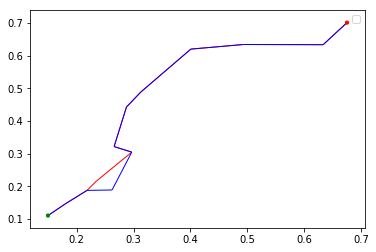

('Dijkstra path :', [68, 24, 3, 61, 18, 30, 42, 47, 11, 97, 50, 16])
('NN path :', [68, 24, 3, 61, 18, 30, 42, 47, 72, 97, 50, 16])

The model is able to find a different path between 9 and 83


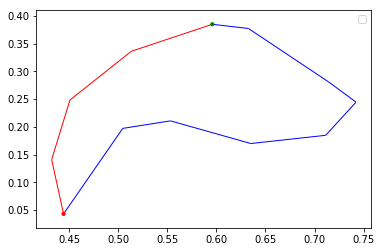

('Dijkstra path :', [9, 94, 78, 25, 83])
('NN path :', [9, 32, 34, 86, 8, 96, 2, 93, 83])

The model is able to find a different path between 81 and 8


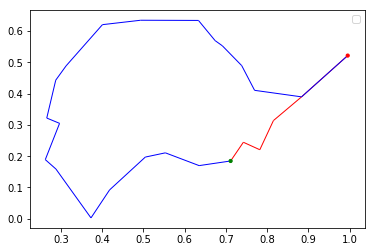

('Dijkstra path :', [81, 41, 7, 26, 96, 8])
('NN path :', [81, 41, 91, 76, 46, 82, 24, 3, 61, 18, 30, 42, 47, 72, 10, 80, 71, 32, 34, 86, 8])

The model is able to find a different path between 10 and 79


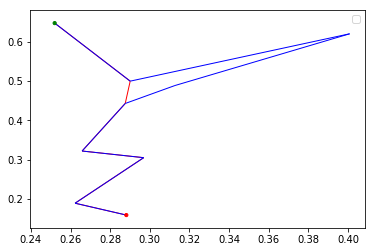

('Dijkstra path :', [10, 72, 47, 42, 30, 1, 79])
('NN path :', [10, 72, 47, 42, 30, 18, 61, 1, 79])

The model is able to find a different path between 80 and 68


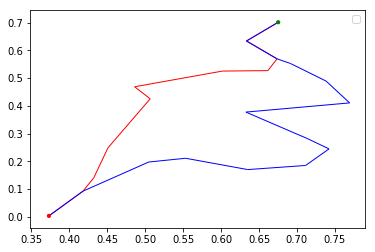

('Dijkstra path :', [80, 71, 94, 78, 59, 20, 74, 70, 82, 24, 68])
('NN path :', [80, 71, 32, 34, 86, 8, 96, 2, 93, 91, 76, 46, 82, 24, 68])



The model is able to find a different path between 33 and 84


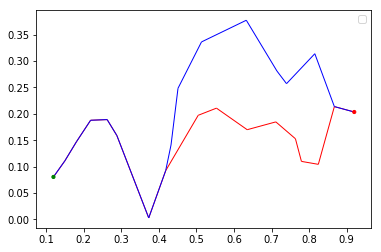

('Dijkstra path :', [33, 31, 66, 27, 85, 8, 86, 34, 32, 71, 80, 10, 72, 97, 50, 16, 84])
('NN path :', [33, 31, 7, 28, 2, 93, 25, 78, 94, 71, 80, 10, 72, 97, 50, 16, 84])



The model is able to find a different path between 34 and 64


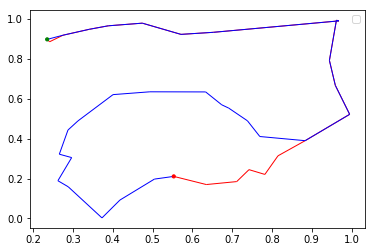

('Dijkstra path :', [34, 86, 8, 96, 26, 7, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 39, 29, 64])
('NN path :', [34, 32, 71, 80, 10, 72, 47, 42, 30, 18, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53, 69, 40, 38, 39, 64])

The model is able to find a different path between 17 and 56


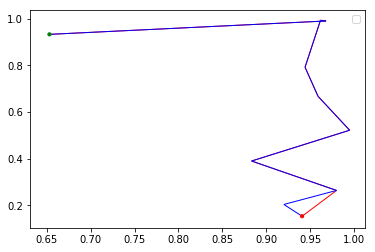

('Dijkstra path :', [17, 19, 41, 81, 52, 14, 13, 37, 56])
('NN path :', [17, 33, 19, 41, 81, 52, 14, 13, 37, 56])

The model is able to find a different path between 35 and 49


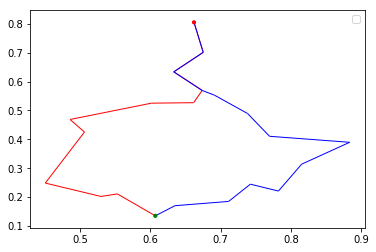

('Dijkstra path :', [35, 68, 24, 82, 70, 74, 20, 59, 78, 63, 34, 49])
('NN path :', [35, 68, 24, 82, 46, 76, 91, 41, 7, 26, 96, 8, 86, 49])

The model is able to find a different path between 63 and 49


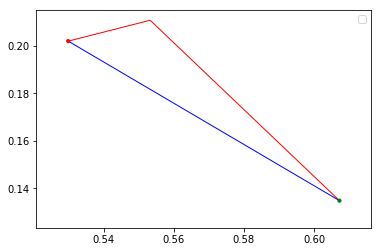

('Dijkstra path :', [63, 34, 49])
('NN path :', [63, 49])



The model is able to find a different path between 89 and 91


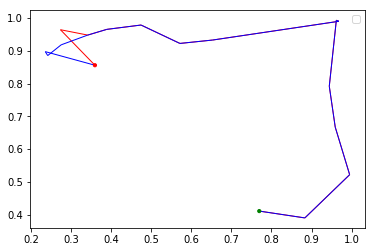

('Dijkstra path :', [89, 98, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91])
('NN path :', [89, 64, 29, 39, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91])

The model is able to find a different path between 42 and 16


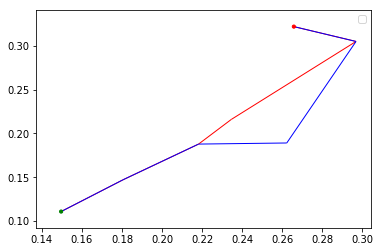

('Dijkstra path :', [42, 47, 11, 97, 50, 16])
('NN path :', [42, 47, 72, 97, 50, 16])

The model is able to find a different path between 2 and 20


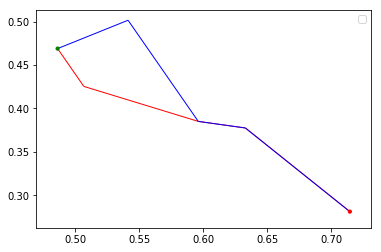

('Dijkstra path :', [2, 93, 83, 59, 20])
('NN path :', [2, 93, 83, 36, 20])

The model is able to find a different path between 19 and 12


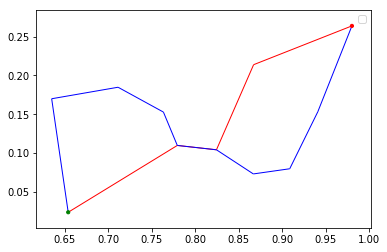

('Dijkstra path :', [19, 31, 66, 27, 12])
('NN path :', [19, 17, 43, 58, 66, 27, 85, 8, 86, 12])



The model is able to find a different path between 6 and 68


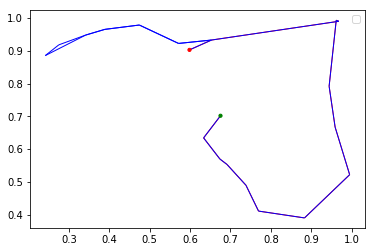

('Dijkstra path :', [6, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 68])
('NN path :', [6, 56, 53, 69, 40, 38, 39, 29, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 91, 76, 46, 82, 24, 68])

The model is able to find a different path between 63 and 72


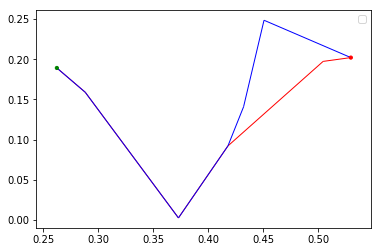

('Dijkstra path :', [63, 32, 71, 80, 10, 72])
('NN path :', [63, 78, 94, 71, 80, 10, 72])

The model is able to find a different path between 25 and 90


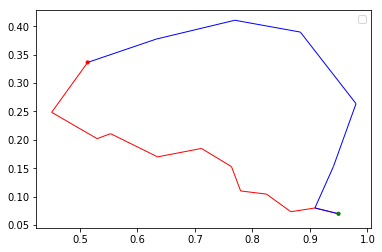

('Dijkstra path :', [25, 78, 63, 34, 86, 8, 85, 27, 66, 58, 43, 90])
('NN path :', [25, 93, 91, 41, 19, 17, 43, 90])

The model is able to find a different path between 25 and 44


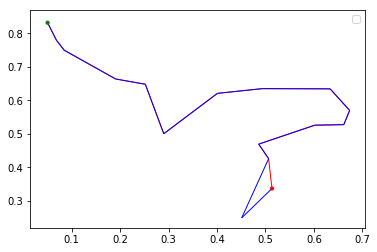

('Dijkstra path :', [25, 59, 20, 74, 70, 82, 24, 3, 61, 1, 79, 54, 51, 21, 44])
('NN path :', [25, 78, 59, 20, 74, 70, 82, 24, 3, 61, 1, 79, 54, 51, 21, 44])

The model is able to find a different path between 10 and 83


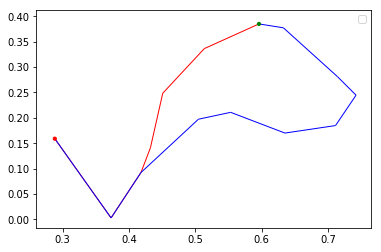

('Dijkstra path :', [10, 80, 71, 94, 78, 25, 83])
('NN path :', [10, 80, 71, 32, 34, 86, 8, 96, 2, 93, 83])

The model is able to find a different path between 84 and 26


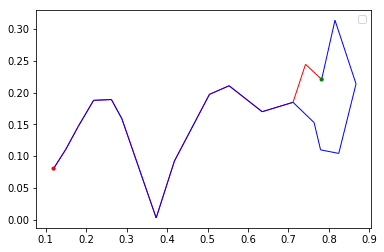

('Dijkstra path :', [84, 16, 50, 97, 72, 10, 80, 71, 32, 34, 86, 8, 96, 26])
('NN path :', [84, 16, 50, 97, 72, 10, 80, 71, 32, 34, 86, 8, 85, 27, 66, 31, 7, 26])

The model is able to find a different path between 83 and 9


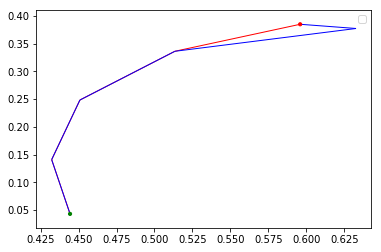

('Dijkstra path :', [83, 25, 78, 94, 9])
('NN path :', [83, 93, 25, 78, 94, 9])

The model is able to find a different path between 31 and 96


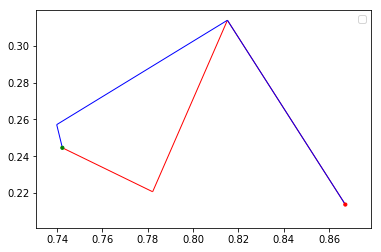

('Dijkstra path :', [31, 7, 26, 96])
('NN path :', [31, 7, 28, 96])

The model is able to find a different path between 98 and 90


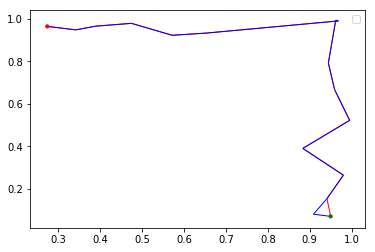

('Dijkstra path :', [98, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 19, 17, 90])
('NN path :', [98, 38, 40, 69, 53, 56, 37, 13, 14, 52, 81, 41, 19, 17, 43, 90])



The model is able to find a different path between 23 and 25


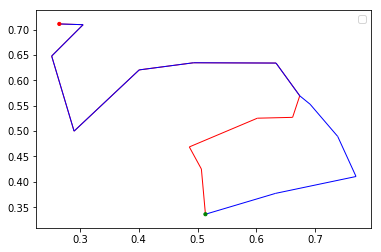

('Dijkstra path :', [23, 67, 79, 1, 61, 3, 24, 82, 70, 74, 20, 59, 25])
('NN path :', [23, 67, 79, 1, 61, 3, 24, 82, 46, 76, 91, 93, 25])



The model is able to find a different path between 10 and 53


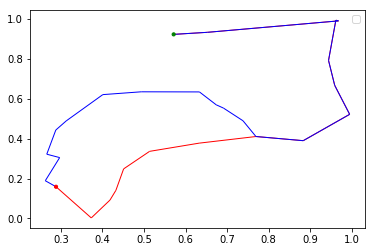

('Dijkstra path :', [10, 80, 71, 94, 78, 25, 93, 91, 41, 81, 52, 14, 13, 37, 56, 53])
('NN path :', [10, 72, 47, 42, 30, 18, 61, 3, 24, 82, 46, 76, 91, 41, 81, 52, 14, 13, 37, 56, 53])

The model is able to find a different path between 18 and 78


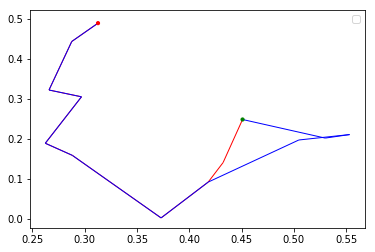

('Dijkstra path :', [18, 30, 42, 47, 72, 10, 80, 71, 94, 78])
('NN path :', [18, 30, 42, 47, 72, 10, 80, 71, 32, 34, 63, 78])



The model is able to find a different path between 62 and 10


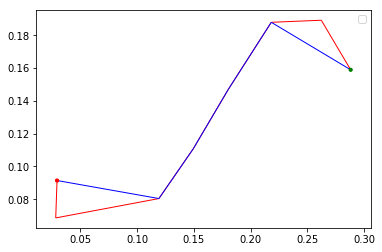

('Dijkstra path :', [62, 92, 84, 16, 50, 97, 72, 10])
('NN path :', [62, 84, 16, 50, 97, 10])

The model is able to find a different path between 17 and 9


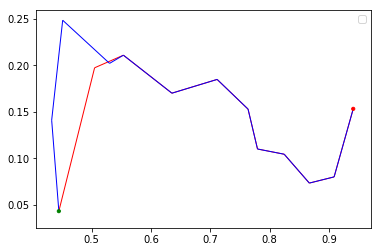

('Dijkstra path :', [17, 43, 58, 66, 27, 85, 8, 86, 34, 32, 9])
('NN path :', [17, 43, 58, 66, 27, 85, 8, 86, 34, 63, 78, 94, 9])

The model is able to find a different path between 3 and 84


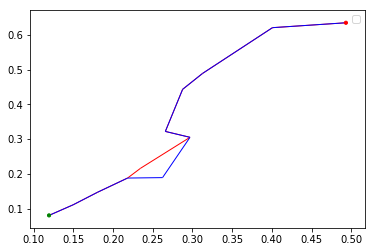

('Dijkstra path :', [3, 61, 18, 30, 42, 47, 11, 97, 50, 16, 84])
('NN path :', [3, 61, 18, 30, 42, 47, 72, 97, 50, 16, 84])

The model is able to find a different path between 71 and 99


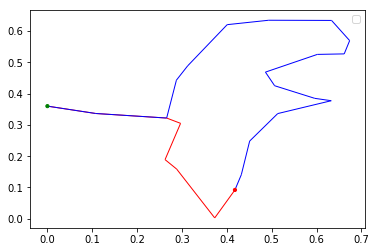

('Dijkstra path :', [71, 80, 10, 72, 47, 42, 15, 99])
('NN path :', [71, 94, 78, 25, 93, 83, 59, 20, 74, 70, 82, 24, 3, 61, 18, 30, 42, 15, 99])

The model is able to find a different path between 49 and 60


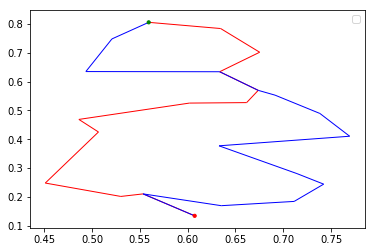

('Dijkstra path :', [49, 34, 63, 78, 59, 20, 74, 70, 82, 24, 68, 5, 60])
('NN path :', [49, 34, 86, 8, 96, 2, 93, 91, 76, 46, 82, 24, 3, 77, 60])

341 out of 400 can find path: 0.852500
177 out of 341 can find optimal path: 0.519062
177 out of 400 all paths can find optimal paths: 0.442500
341 pairs, μ=0.893202, σ=0.238734
341 pairs, μ=0.889124, σ=0.188265


In [236]:
num_node_pairs = 400

_, _, G_test, pair_path_dict = generate_samples_from_graph(num_node_pairs=num_node_pairs, graph_size=100, augmentation=False, label='Test')
print_paths_statistics(G_test, num_to_test=num_node_pairs, pair_path_dict=pair_path_dict)

In [145]:
def plot_dijkstra_nn_comparison(G, dijkstra_node_list, nn_node_list):

    pos = {}

    for node in dijkstra_node_list:
        pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    dijkstra_edge_list = []
    for idx, node in enumerate(dijkstra_node_list[:-1]):
        dijkstra_edge_list.append((node, dijkstra_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=pos, edgelist=dijkstra_edge_list, node_size=20, edge_color='r')
    nn_pos = {}

    for node in nn_node_list:
        nn_pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    nn_edge_list = []
    for idx, node in enumerate(nn_node_list[:-1]):
        nn_edge_list.append((node, nn_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=nn_pos, edgelist=set(nn_edge_list), node_size=100, edge_color='b')
    
    nx.draw_networkx_nodes(G, pos=pos,\
                           nodelist=[dijkstra_node_list[0], dijkstra_node_list[-1]],\
                           node_size=10,\
                           node_color=['r', 'g'])
    
    plt.legend(loc='best')
    plt.show()

# Some Analysis

It seems that in the cases where the model fails to find a path, the model is trapped in a dead loop; however, at the early stage of inference, the generated path is not absolute
nonsense. At some point, the model makes a dubious turn and the paths are likely to diverge.

The model has learned, to some extent, to crawl its way back to where it made a mistake and
make it to the destination; 

this is understandable since the training set sampling is bidirectional; 
more specifically, whenever a pair of nodes are selected, the paths from 
both directions are calculated and recorded; this provides the model with
the information about how to get back when the current path chosen is too
wrong.

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-22 11:41:41.556830. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


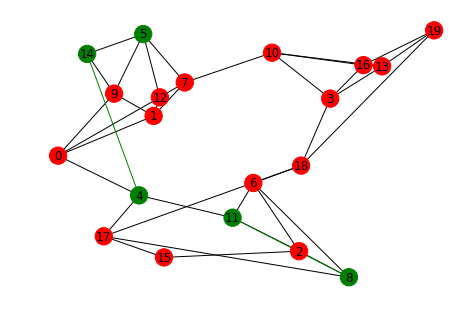

In [98]:
pos = {}
for t in G.nodes.items():
    pos[t[0]] = (t[1]['x'], t[1]['y'])

path_edge_list = [(node, path[idx+1]) for idx, node in enumerate(path[:-1])]

edge_colors = [ 'g' if edge in path_edge_list else 'k' for edge in G.edges()]
node_colors = [ 'g' if node in path else 'r' for node in G.nodes()]
nx.draw(G, with_labels=True, pos=pos,\
           nodelist=G.nodes(),\
           node_size=300,\
           node_color=node_colors,\
           edgelist=G.edges(),\
           edge_color=edge_colors,
           linewidths=1.0)
plt.show()